# Text Mining - Document Summary

History:

- 2017/9/7: 
    - 移除文章內的google廣告語法
    - 用逗號和問號斷句
    - 加入similar words
        - check read01_summary
    - 加入兩張圖(tf-idf keywords, similar words)
        - check keywordmap
- 2017/9/11:
    - 建立user dict
    - 用jieba抓tfidf key words
- 2017/9/12:

  

Reference:
- 用scikit-learn学习LDA主题模型
    - http://www.cnblogs.com/pinard/p/6908150.html
    - http://blog.csdn.net/eastmount/article/details/50824215
    
- 中文文本挖掘预处理流程总结
    - http://www.cnblogs.com/pinard/p/6744056.html
    
- Mining English and Korean text with Python
    https://www.lucypark.kr/courses/2015-ba/text-mining.html
    
- NLTK (POS, chunk, Parser tree)    
    - http://aweiho2015.pixnet.net/blog/post/10269587-%5B%E8%AA%8D%E8%AD%98%E8%87%AA%E7%84%B6%E8%AA%9E%E8%A8%80%E8%99%95%E7%90%86%28text-mining%29%5D--%E5%A6%82%E4%BD%95%E8%99%95%E7%90%86%E4%B8%80%E5%8F%A5
    
- TF-IDF and TextRank
    - http://zhicongchen.github.io/2016/11/22/TF-IDF-and-TextRank/
    
- 中文斷詞：斷句不要悲劇 / Head first Chinese text segmentation    
    - https://speakerdeck.com/fukuball/head-first-chinese-text-segmentation



## Outline

-  [斷詞 (Jieba)]()
-  [計算高頻詞 (TF-IDF)]()
-  [Key words and key sentence summary]()
-  [Word Embedding (word2vec)]()  
-  [降維 (T-SNE)]()
-  [key word map]()





** TODO **

9/2: 
1. Ontology, 搜尋, 分類
2. 每首歌的屬性, Josh做的5大象限
3. 每首歌的知識圖譜?
    - http://bangqu.com/J8z3Dx.html 
    
4. Summary:
    - v1. 取每首歌的前3個關鍵字, 用包含這三個關鍵字的句子當做summary
    - v3. 用每首歌的前3個關鍵字當作3個topic, 找到包含這三個關鍵字的句子與其相似的句子做出三段summary


    


In [620]:
import os
import pandas as pd
import numpy as np

import langconv as langconv
conveter = langconv.Converter('zh-hant')

import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt

import jieba
import jieba.analyse
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer  
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
import re
import ast

import random
from flask import Flask, g, render_template, request
import logging
import html_template as ht
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import collections
import pickle

from collections import OrderedDict
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)

%matplotlib inline

pd.set_option('display.max_columns', None)
punct = u'''\n +-％%:!),.:;?]}¢'"、。〉》」』】〕〗〞︰︱︳丨﹐､﹒﹔﹕﹖﹗﹚﹜﹞！），．：；？｜｝︴︶︸︺︼︾﹀﹂﹄﹏､～￠々‖•·ˇˉ―′’”([{£¥'"‵〈《「『【〔〖（［｛￡￥〝︵︷︹︻︽︿﹁﹃﹙﹛﹝（｛“‘—_…~/#><'''
jieba.set_dictionary('dict.txt.big')

/Users/jayhsu/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [9]:
fp = matplotlib.font_manager.FontProperties(fname = 'font/NotoSansCJKtc-Regular.otf')
matplotlib.font_manager.fontManager.ttffiles.append(fp.get_file())
font_entry = matplotlib.font_manager.FontEntry(fp.get_file(), name=fp.get_name(),
                                               style=fp.get_style(), variant=fp.get_variant(),
                                              weight=fp.get_weight(), stretch=fp.get_stretch(), size=fp.get_size())

matplotlib.font_manager.fontManager.ttflist.append(font_entry)
plt.rcParams['font.family'] = fp.get_name()

** 斷詞, CountVectorizer, TfidfTransformer, Summary**

** 一篇文章分析 ** 

In [736]:
dl_df, dl_voc_dic, dl_vockey_dic, dl_w2v_model, dl_pca = read01_summary(folder = 'text/techdoc', topic='深度學習',kw_topn=50)


** 1. 檢查斷詞效果 **

In [14]:
docid=13
print('斷詞:')
print(', '.join(list(dl_df['words'][docid])))

斷詞:


 - 把需要修正的詞加入自訂義字典 
 - 紀錄load_userdict後仍然斷錯的

In [449]:
jieba.load_userdict('userdict.txt')

** 2. extract key words **

 - TF-IDF (IDF: 100篇read01的深度學習文章)

keywords:


,keyword,tfidf,tf
0,digits,0.391,0.016603
1,titan,0.271,0.011494
2,深度,0.232,0.030651
3,devbox,0.231,0.007663
4,nvidia,0.191,0.010217
5,gpu,0.167,0.014049


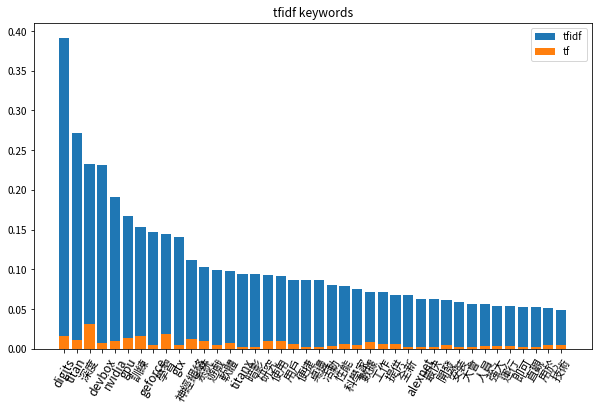

In [746]:
print('keywords:')
#print(', '.join(list(v['keywords'][docid])))
kw_x, kw_y = zip(*(dl_df['keywords_w'][docid][:40]))
kw_y = list(map(lambda x: float('%.3f'% x),kw_y))


tfvec=dl_df['tf_vector'][docid]
tfidf_df = pd.DataFrame({'keyword':kw_x, 'tfidf':kw_y})
tfidf_df['tf']=tfidf_df['keyword'].map(lambda x: tfvec[dl_vockey_dic[x]])
display(tfidf_df[:6])

plt.figure(figsize=(10,6))
plt.bar(range(len(kw_y)), kw_y, label='tfidf')
plt.bar(range(len(kw_y)), tfidf_df['tf'], label='tf')
plt.xticks(range(len(kw_x)), kw_x,rotation=60, fontsize=12)
plt.legend()
plt.title('tfidf keywords')


 - TF-IDF (IDF: jieba內建語料庫)

keywords_jb:


,keyword,tfidf,tf
0,學習,0.327,0.019157
1,深度,0.304,0.030651
2,訓練,0.283,0.016603
3,DIGITS,0.283,0.016603
4,GPU,0.240,0.014049
5,神經網絡,0.218,0.012771


(0, 0.4)

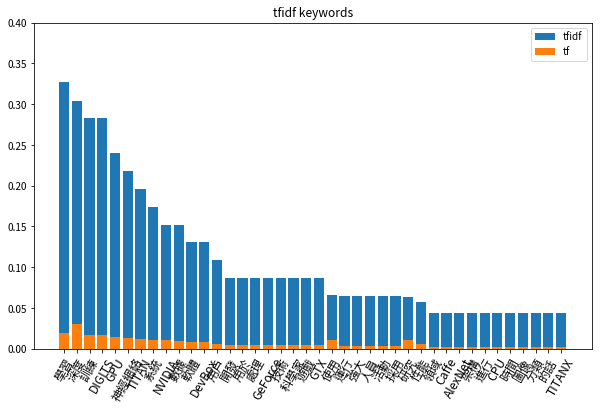

In [749]:
print('keywords_jb:')
kw_x, kw_y = zip(*(dl_df['keywords_jb'][docid][:40]))
kw_y = list(map(lambda x: float('%.3f'% x),kw_y))

tfvec=dl_df['tf_vector'][docid]
tfidf_df = pd.DataFrame({'keyword':kw_x, 'tfidf':kw_y})
tfidf_df['tf']=tfidf_df['keyword'].map(lambda x: tfvec[dl_vockey_dic[x.lower()]])
display(tfidf_df[:6])

plt.figure(figsize=(10,6))
plt.bar(range(len(kw_y)), kw_y, label='tfidf')
plt.bar(range(len(kw_y)), tfidf_df['tf'], label='tf')
plt.xticks(range(len(kw_x)), kw_x,rotation=60, fontsize=12)
plt.legend()
plt.title('tfidf keywords')
plt.ylim(0,0.4)


**3. Topic **

  - word2vec word similarity 

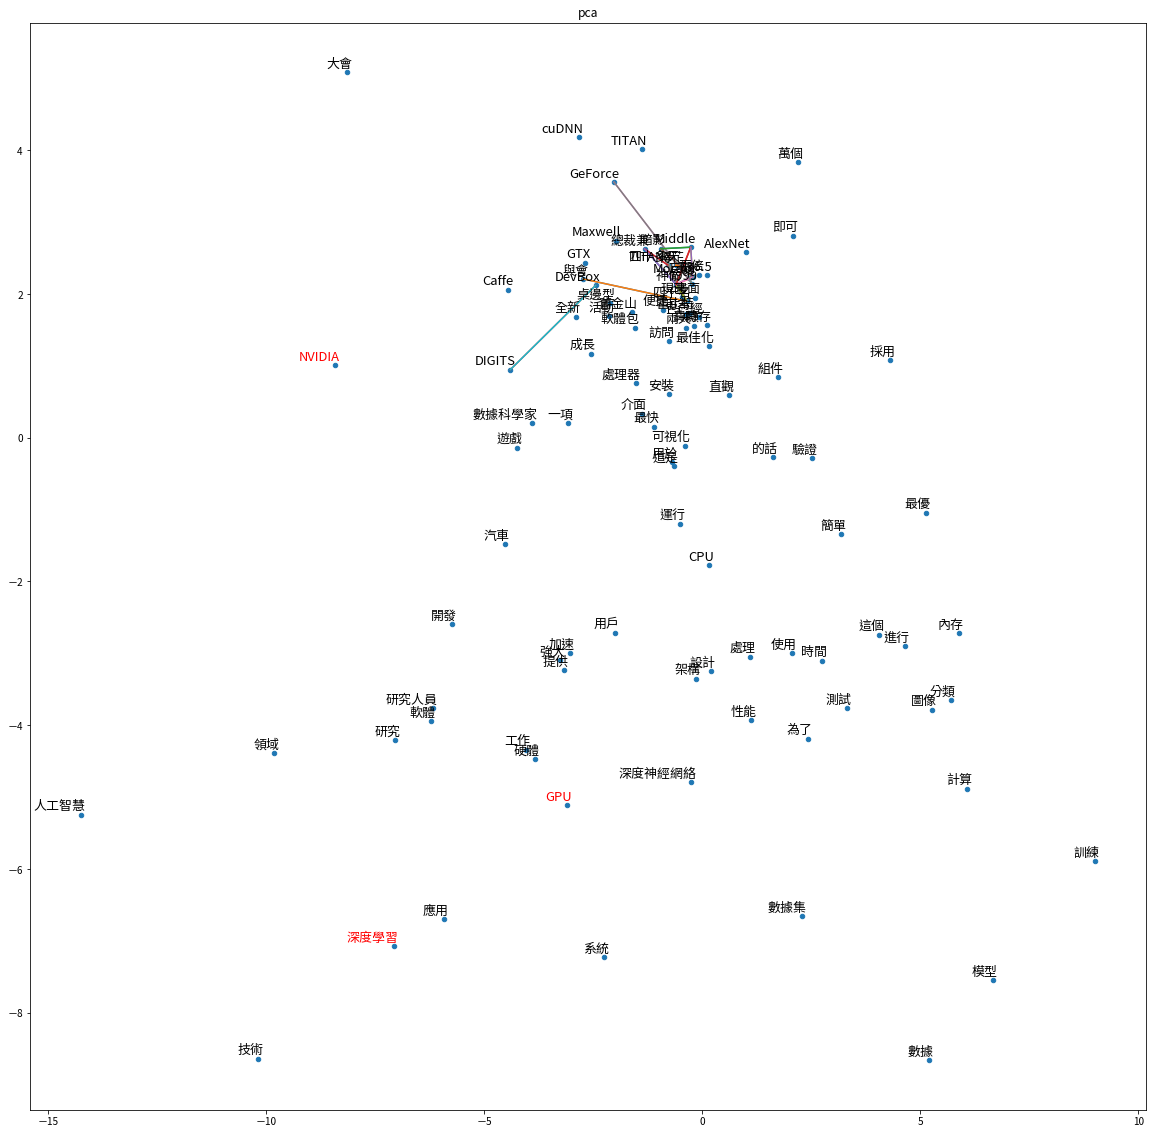

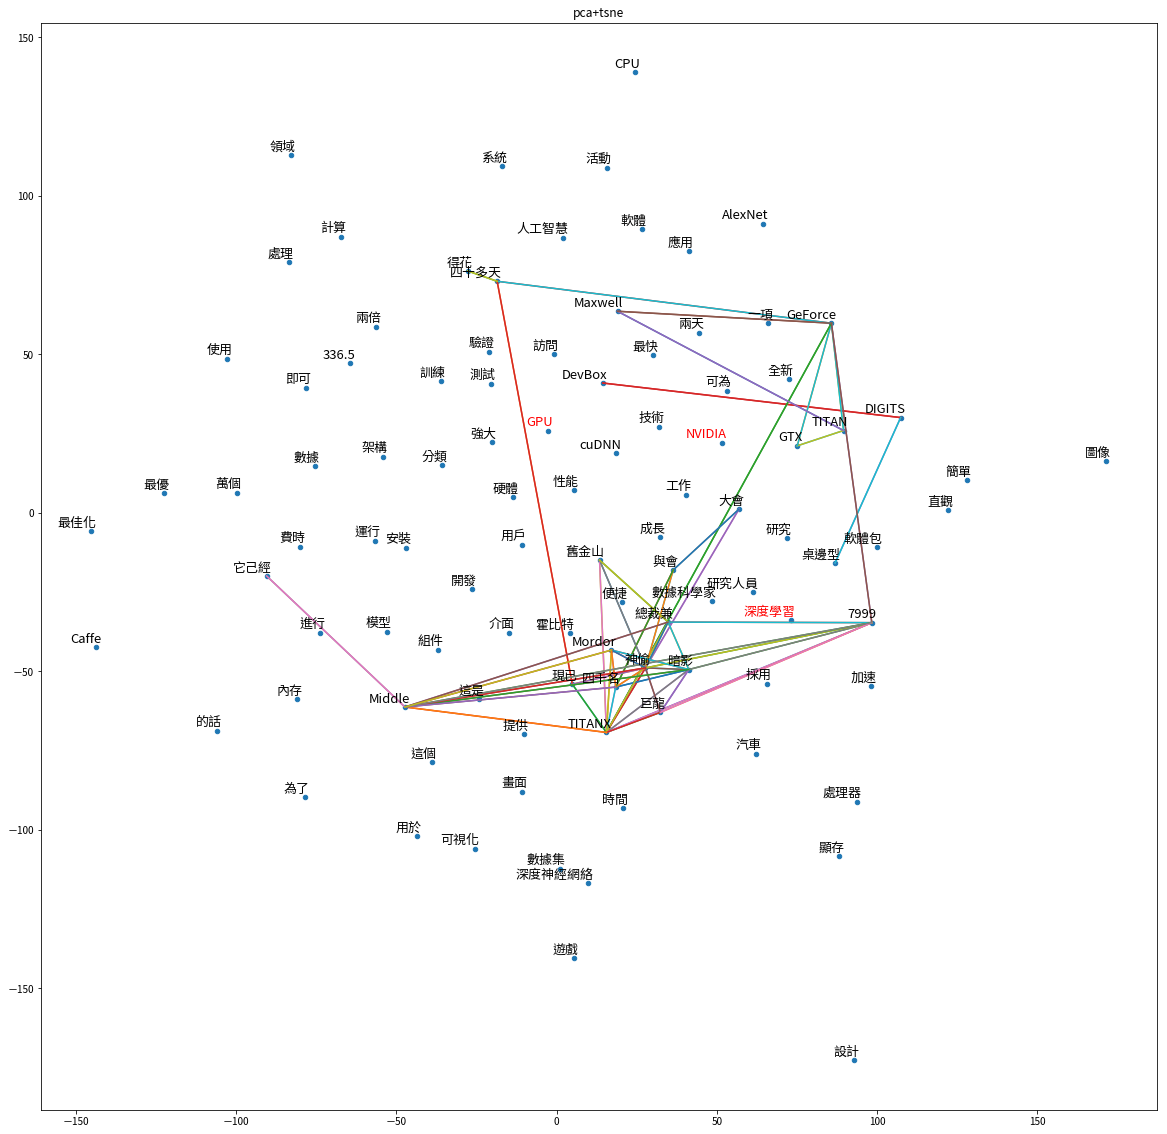

In [459]:
keywords_predefined = ['NVIDIA', '黃仁勛', 'GPU', '深度學習']

kw_x = jieba.analyse.tfidf(dl_df['doc'][docid],topK=100, withWeight=False)
#kw_x = jieba.analyse.textrank(dl_df['doc'][docid],topK=100, withWeight=False)
vec_kw = [list(dl_w2v_model[w.lower()]) for w in kw_x]

vec_pca = dl_pca.transform(vec_kw)
tsne = TSNE(perplexity=10, n_components=2, init='pca', n_iter=10000,)
vec_tsne = tsne.fit_transform(vec_pca)

plt.clf()
fig = plt.figure(figsize=(20,20))
plt.scatter(vec_pca[:, 0], vec_pca[:, 1], s= 20, label='top 100 words')
for i, label in enumerate(kw_x):
    x, y = vec_pca[i][:2]
    if label in keywords_predefined:
        color = 'red'
    else:
        color='black'
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 fontsize=13,
                 color=color,
                 ha='right',
                 va='bottom')

for i1, label_1 in enumerate(kw_x):
    x1, y1 = vec_pca[i1][:2]
    for i2, label_2 in enumerate(kw_x):
        x2, y2 = vec_pca[i2][:2]
        similarity = dl_w2v_model.similarity(label_1.lower(), label_2.lower())
        if(similarity>0.7):
            plt.plot([x1,x2], [y1,y2])
plt.title('pca')
    
    
fig = plt.figure(figsize=(20,20))
plt.scatter(vec_tsne[:, 0], vec_tsne[:, 1], s= 20, label='top 100 words')
for i, label in enumerate(kw_x):
    x, y = vec_tsne[i][:2]
    if label in keywords_predefined:
        color = 'red'
    else:
        color='black'
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 fontsize=13,
                 color=color,
                 ha='right',
                 va='bottom')

for i1, label_1 in enumerate(kw_x):
    x1, y1 = vec_tsne[i1][:2]
    for i2, label_2 in enumerate(kw_x):
        x2, y2 = vec_tsne[i2][:2]
        similarity = dl_w2v_model.similarity(label_1.lower(), label_2.lower())
        if(similarity>0.6):
            plt.plot([x1,x2], [y1,y2])
plt.title('pca+tsne')

- LDA 

In [640]:
topic_num = 5
doc = dl_df['doc_tmp'][13]
paragraph = doc.split('\n')

paragraph_cutstrlist=[]
for p in paragraph:
    if p =='...':
        continue
    p_cut = jieba.cut(p)
    p_cut_str = ' '.join(p_cut)
    paragraph_cutstrlist.append(p_cut_str)
    
#从文件导入停用词表
stpwrdpath = "model/stop_words.txt"
stpwrd_dic = open(stpwrdpath, 'r')
stpwrd_content = stpwrd_dic.read()
#将停用词表转换为list  
stpwrdlst = stpwrd_content.splitlines()
stpwrd_dic.close()

cntVector = CountVectorizer(stop_words=stpwrdlst)
cntTf = cntVector.fit_transform(paragraph_cutstrlist)
fea = cntVector.get_feature_names()
lda = LatentDirichletAllocation(n_topics=topic_num,
                                learning_offset=50.,
                                random_state=0)
docres = lda.fit_transform(cntTf)

topiclist = np.argmax(docres, axis=1)
doc_topic = pd.DataFrame({ 'sentence:':paragraph_cutstrlist,'topic':topiclist})
display(doc_topic.sort_values(by='topic'))


lda_kwlist= []
for i in lda.components_:
    kw, weight = sort2list(i, fea)
    lda_kwlist.append(zip(kw,weight))
topic_kw = pd.DataFrame(lda_kwlist)
display(topic_kw.transpose())

/Users/jayhsu/anaconda/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


,sentence:,topic
23,它己經 預先 安裝 了 數據 科學家 和 研究 人員 在 開發 自己 的 深度 神經網絡 時 ， 所 需要 使用 到 的 各種 軟體 ， 包括 DIGITS 軟體 包 、 最 受歡迎 的 深度 學習 架構 一 Caffe 、 Theano 和 Torch ， 還有 NVIDIA 完整 的 GPU 加速 深度 學習 庫 cuDNN 2.0 。,0
2,NVIDIA 聯合 創始人 、 總裁兼 執行長 黃 仁 勛 先生 在 GPU 技術 大會 的 開幕 主題 演講 活動 上 ， 對 在座 的 四千名 與會 嘉賓 展示 三項 將 推動 深度 學習 的 新 技術 ：,0
3,· NVIDIA GeForce GTX TITAN X - 為 訓練 深度 神經網絡 而 開發 的 最 強大 的 處理器 。,0
5,· DIGITS DevBox - 全球 最快 的 桌邊 型 深度 學習 工具 - 專為 相關 任務 而 打造 ， 採用 TITAN X GPU ， 搭配 直觀 易用 的 DIGITS 訓練 系統 。,0
6,GeForce GTX TITAN X 的 另一面,0
21,NVIDIA 深度 學習 工程 團隊 為 了 自己 的 研發 工作 而 開發 的 DIGITS DevBox ， 是 一套 集 多項 功能 於 一身 的 平台 ， 能夠 加快 深度 學習 的 研究 活動 。,0
20,DIGITS DevBox ： 全球 最快 的 桌邊 型 深度 學習 機器,0
18,得益於 其 直觀 的 用戶 介面 和 強大 的 工作 流程 管理 能力 ， 不論是 在 本地 系統 還是 在 網絡 上 使用 DIGITS ， 準備 和 加載 訓練 數據 集都 相當 簡單 。,0
11,憑藉 強大 的 處理 能力 和 336.5 GB / s 的 帶寬 ， 讓 它 能 處理 用於 訓練 深度 神經網絡 的 數百萬 的 數據 。 例如 ， TITAN X 在 工業 標準 模型 AlexNet 上 ， 花 了 不到 三天 的 時間 、 使用 120 萬個 ImageNet 圖像 數據 集去 訓練 模型 ， 而 使角 16 核心 的 CPU 得花 上 四十多天 。,0
17,DIGITS 可 在 安裝 、 配置 和 訓練 深度 神經網絡 過程 中為 用戶 提供 指導 一 處理 複雜 的 工作 好 讓 科學家 能 專心 在 研究 活動 和 結果 上 。,0


,0,1,2,3,4
0,"(5.98806807181, 深度)","(3.50874705003, google)","(1.21483604056, digits)","(2.10518130156, titan)","(3.83404854439, 深度)"
1,"(3.85129948388, digits)","(2.02602915158, 使用)","(1.13074175064, 採用)","(1.99463698626, 深度)","(3.40600676194, google)"
2,"(3.56121866854, 學習)","(1.94651810691, devbox)","(1.01695077106, 相關)","(1.97050954004, 性能)","(3.06028290586, 系統)"
3,"(3.21007016661, 訓練)","(1.91701618297, gpu)","(0.997033683658, 打造)","(1.65132395988, 技術)","(2.585554603, 神經網絡)"
4,"(2.88866262801, 神經網絡)","(1.66709278711, 可以)","(0.971392795096, 任務)","(1.64518996446, 領域)","(2.52048415599, gpu)"
5,"(2.49035193584, nvidia)","(1.62323991549, 性能)","(0.961215062094, gpu)","(1.58918951096, nvidia)","(2.50998716829, 訓練)"
6,"(2.41498802932, 數據)","(1.60241878353, join)","(0.953678689203, 專為)","(1.57565939531, 研究)","(2.50697606271, 學習)"
7,"(2.28662205806, titan)","(1.60070691037, digits)","(0.94368212195, 深度)","(1.51556110721, 學習)","(2.04535074872, 數據)"
8,"(2.12480732677, 研究)","(1.57972114016, params)","(0.93850024795, 直觀)","(1.50768762058, 軟體)","(2.02894324209, 用戶)"
9,"(2.11380665773, 活動)","(1.56546093067, 1528)","(0.929217812784, 桌邊)","(1.26033843118, 功用)","(2.00035137091, 用於)"


** Ontology / Knowledge map **

Key words:
1. 把文章印出來
2. 標出關鍵字
3. Jieba斷字有沒有錯誤？ -> 建立斷詞字典-positive
4. 關鍵字裡面有沒有需要加入stop words的字？ -> 建立斷詞字典-negagive
5. AI找到的關鍵字和HI找到的差異比對, 
  - AI漏掉的, 為什麼漏掉？
  - HI漏掉的, 為什麼漏掉？
  
6. 利用關鍵字建立第一版Ontology分類架構  
 


Similar Words:
   - 已知的關聯：分類架構
   - 位置的關聯：？？？
    
    



***

In [41]:
def sort2list(list1, list2):
    list1, list2 = (list(t) for t in zip(*sorted(zip(list1, list2),reverse=True)))
    return list1, list2

def keywords(row, voc_dic, kwtopn=3, withWeight=False):
    keywork_list=[]
    keyworkWweight_list=[]
    tfidf_vec = row['tfidf_vector']
    topn = list(set(tfidf_vec))
    topn.sort(reverse=True)
    for top in topn[:kwtopn]:
        if top==0:
            continue
        winner = np.argwhere([x ==top for x in tfidf_vec ])
        idxlist =winner.flatten().tolist() 
        for i in idxlist:
            keywork_list.append(voc_dic.get(i))
            keyworkWweight_list.append((voc_dic.get(i), top)  )
        if len(keywork_list)>=kwtopn:
            break
    if withWeight:
        return tuple(keyworkWweight_list) 
    else:
        return tuple(keywork_list) 
    


def docsummary(row):
    doc_list = row['sentences']
    keywords = row['keywords']
    if keywords:
        keysentencelist=[]
        for doc in doc_list:
            doc = doc.lower()
            for kw in keywords:
                if kw in doc and doc not in keysentencelist:
                    keysentencelist.append(doc)
                    
        #summary_str = ','.join(keysentencelist)
        summary_str=''
        strlen = 0
        for sen in keysentencelist[:10]:
            if strlen>50:
                strlen = len(sen)
                summary_str=summary_str+',\n'+sen
            else:
                strlen = strlen + len(sen)
                summary_str=summary_str+','+sen
    else:
        summary_str='NA'
        
    return summary_str


** 歌詞 **

#who_list = ['easonchen','jaychou', 'karenmok','831','mayday']
who_list=[w for w in os.listdir('text_dl') if not w.startswith('.')]
update=True
if update:
    jieba.set_dictionary('dict.txt.big')
    for who in who_list:
        skipwords=()
        df = lyrics_summary('text_dl', who, skipwords=skipwords)
        #lyrics_df.to_csv('static/data/lyrics_{w}.csv'.format(w=who))
        #fh = open('static/data/lyrics_{w}.pkl'.format(w=who), 'wb')
        #pickle.dump(lyrics_df, fh)
        

        

** Text in a specific topic **

In [725]:
dl_df['idf_vector'] = dl_df['tfidf_vector']/dl_df['tf_vector']

In [735]:
exlist=['adsbygoogle','...']
def read01_summary(folder, topic, kw_topn=3):
    files = os.listdir('{f}/{w}'.format(f=folder, w=topic))
    docs=[]
    fileName=[]
    
    for fidx, fname in enumerate(files):
        if fname.startswith('.') or fname.endswith('.flag') :
            continue

        file = open('{fd}/{w}/{f}'.format(fd=folder, w=topic, f=fname), 'r') 
        doc =[] 
        for line in file.readlines():                          
            line = line.strip()
            if not len(line):                               
                continue                                    
            doc.append(line) 
        if len(doc)==0:
            continue
        docs.append('\n'.join(doc))
        fileName.append(str(fidx)+'_'+fname)

    dl_df = pd.DataFrame({'fname':fileName, 'doc_tmp':docs})
    dl_df.sort_values(by='fname')
    dl_df['sentences']=dl_df['doc_tmp'].map(lambda x: re.split("[\n\r，。？]+", x))
    dl_df['sentences']=dl_df['sentences'].map(lambda x: [s for s in x if not any(w in s for w in exlist)])    
    dl_df['doc']=dl_df['sentences'].map(lambda x: '\n'.join(x))
    dl_df['words'] =   dl_df['doc'].map(lambda x: [_.lower() for _ in jieba.cut(x) if _ not in punct]) 
    dl_df['words_str'] = dl_df['words'].map(lambda x: ' '.join(x))

    cv = CountVectorizer()
    vecs1 = cv.fit_transform(dl_df['words_str']).toarray()
    
    doclen= list(dl_df['words'].map(lambda x:len(x)))
    tf_vec = [(a/b).tolist() for a,b in zip(vecs1.tolist(), doclen)]
    dl_df['tf_vector'] = tf_vec
    fea = cv.get_feature_names()
    key = range(len(fea))
    voc_dic = dict(zip(key, fea))
    vockey_dic = dict(zip(fea, key))
    tfidf = TfidfTransformer()
    vecs2 = tfidf.fit_transform(vecs1).toarray()
    dl_df['tfidf_vector'] = [_ for _ in vecs2]
    
    dl_df['keywords'] = dl_df.apply(keywords, axis=1, args=(voc_dic,kw_topn,False))
    dl_df['keywords'] = dl_df['keywords'].map(list)
    
    dl_df['keywords_w'] = dl_df.apply(keywords, axis=1, args=(voc_dic,kw_topn,True))
    
    dl_df['keywords_jb'] = dl_df['doc'].map(lambda x: jieba.analyse.tfidf(x,topK=kw_topn, withWeight=True))
    dl_df['keywords_jb'] = dl_df['keywords_jb'].map(list)
    
    dl_df['keywords_jb'] = dl_df['doc'].map(lambda x: jieba.analyse.extract_tags(x,topK=kw_topn, withWeight=True))
    dl_df['keywords_jb'] = dl_df['keywords_jb'].map(list)
    
    dl_df['summary'] = dl_df.apply(docsummary, axis=1)
    
    dl_w2v_model = Word2Vec(dl_df['words'], min_count=1, size=100,iter=50)
    
    #dl_df['similarwords'] =  dl_df['keywords'].map(lambda x: [dl_w2v_model.most_similar(kw , topn=5) for kw in x])
    
    all_keywords = sum(list(dl_df['keywords']),[])
    vec = np.array([dl_w2v_model[w] for w in all_keywords if w in dl_w2v_model ])
    dl_pca = PCA(20)
    dl_pca.fit(vec)
    
    return dl_df, voc_dic,vockey_dic, dl_w2v_model, dl_pca

In [425]:
def lyrics_summary(folder, topic, skipwords=('作詞','作曲','編曲','監製')):
    files = os.listdir('{f}/{w}'.format(f=folder, w=topic))
    docs=[]
    fileName=[]
    pattern = re.compile("\[\d+\:\d+\.\d+\]")
    
    for fidx, fname in enumerate(files):
        if fname.startswith('.') or fname.endswith('.flag') :
            continue

        file = open('{fd}/{w}/{f}'.format(fd=folder, w=topic, f=fname), 'r') 
        doc =[] 
        for line in file.readlines():                          
            line = line.strip()
            hastimeflag=pattern.match(line)
            hasskipwords = line.startswith(skipwords)
            if hastimeflag or hasskipwords:
                continue
            if not len(line):                               
                continue                                    
            doc.append(line) 
        if len(doc)==0:
            continue
        docs.append('\n'.join(doc))
        fileName.append(str(fidx)+fname)

    lyrics_df = pd.DataFrame({'fname':fileName, 'doc':docs})
    lyrics_df['sentences']=lyrics_df['doc'].map(lambda x: re.split("[\n\r，。？]+", x))
    lyrics_df['words'] =   lyrics_df['doc'].map(lambda x: [_.lower() for _ in jieba.cut(x) if _ not in punct]) 
    lyrics_df['words_str'] = lyrics_df['words'].map(lambda x: ' '.join(x))

    cv = CountVectorizer()
    vecs1 = cv.fit_transform(lyrics_df['words_str']).toarray()
    fea = cv.get_feature_names()
    key = range(len(fea))
    voc_dic = dict(zip(key, fea))
    tfidf = TfidfTransformer()
    vecs2 = tfidf.fit_transform(vecs1).toarray()
    lyrics_df['tfidf_vector'] = [_ for _ in vecs2]

    lyrics_df['keywords'] = lyrics_df.apply(keywords, axis=1, args=(voc_dic,))
    lyrics_df['keywords'] = lyrics_df['keywords'].map(list)
    lyrics_df['summary'] = lyrics_df.apply(docsummary, axis=1)
    
    dl_w2v_model = Word2Vec(lyrics_df['words'], min_count=1, size=100,iter=20)
    lyrics_df['similarwords'] =  lyrics_df['keywords'].map(lambda x: [dl_w2v_model.most_similar(kw , topn=5) for kw in x])
    all_keywords = sum(list(lyrics_df['keywords']),[])
    vec = np.array([dl_w2v_model[w] for w in all_keywords if w in dl_w2v_model ])
    dl_pca = PCA(20)
    dl_pca.fit(vec)
    return lyrics_df, voc_dic, dl_w2v_model, dl_pca

** Mark 會議記錄 **

In [6]:
def mark_summary():
    mark_df = pd.read_csv('text/mark_srt/extract_mark_srt.csv',encoding='utf-16', index_col=False)
    docs = mark_df['others'].unique()
    tmp=[]
    for doc in docs:
        if doc =='=====':
            continue
        sentences = mark_df[mark_df['others']==doc]['mark']
        sentences = sentences.dropna()
        sentences = list(sentences)
        tmp.append( (doc,sentences))
    mark_df = pd.DataFrame(tmp, columns = ['fname','sentences'])
    mark_df = pd.DataFrame(tmp, columns = ['fname','sentences'])
    mark_df['doc'] = mark_df['sentences'].map(lambda x: '\n'.join(x))
    mark_df['words'] =   mark_df['doc'].map(lambda x: [_.lower() for _ in jieba.cut(x) if _ not in punct]) 
    mark_df['words_str'] = mark_df['words'].map(lambda x: ' '.join(x))

    cv = CountVectorizer()
    vecs1 = cv.fit_transform(mark_df['words_str']).toarray()
    fea = cv.get_feature_names()
    key = range(len(fea))
    voc_dic = dict(zip(key, fea))
    #len(voc_dic)
    tfidf = TfidfTransformer()
    vecs2 = tfidf.fit_transform(vecs1).toarray()
    mark_df['tfidf_vector'] = [_ for _ in vecs2]

    mark_df['keywords'] = mark_df.apply(keywords, axis=1,args=(voc_dic,))
    mark_df['keywords'] = mark_df['keywords'].map(list)
    mark_df['summary'] = mark_df.apply(docsummary, axis=1)
    
    dl_w2v_model = Word2Vec(mark_df['words'], min_count=1, size=100,iter=20)
    mark_df['similarwords'] =  mark_df['keywords'].map(lambda x: [dl_w2v_model.most_similar(kw , topn=5) for kw in x])
    all_keywords = sum(list(mark_df['keywords']),[])
    vec = np.array([dl_w2v_model[w] for w in all_keywords if w in dl_w2v_model ])
    dl_pca = PCA(20)
    dl_pca.fit(vec)
    
    return mark_df, voc_dic, dl_w2v_model, dl_pca
    


In [7]:
def keywordmap(lyrics_df, idx, w2v_model,pca,voc_dic, kw_size=30):
    figures=[]
    all_keywords = sum(list(lyrics_df['keywords']),[])
    counter = collections.Counter(all_keywords)
    if len(set(all_keywords)) <100:
        samples = len(set(all_keywords))
    else:
        samples = 100
    topn_keywords = [w[0] for w in counter.most_common(samples)]
    this_keyword = lyrics_df['keywords'][idx]

    vec = np.array([w2v_model[w] for w in (topn_keywords+this_keyword)])

    vec_pca = pca.transform(vec)
    topn_pca = vec_pca[:samples]
    this_pca = vec_pca[samples:]

    tsne = TSNE(perplexity=10, n_components=2, init='pca', n_iter=10000)
    lowdim_embs = tsne.fit_transform(vec_pca)

    topn_lowdim_embs = lowdim_embs[:samples]
    this_lowdim_embs = lowdim_embs[samples:]
    
    plt.clf()
    fig = plt.figure(figsize=(20,10))
    figures.append(fig)
    plt.subplot(121)
    plt.scatter(topn_lowdim_embs[:, 0], topn_lowdim_embs[:, 1], s= 20, label='top 100 words')
    plt.scatter(this_lowdim_embs[:, 0], this_lowdim_embs[:, 1], s= 50, label='this topic key words', color='orange')
    plt.legend()
    plt.title('PCA + T-SNE')
    for i, label in enumerate(topn_keywords):
        if label in this_keyword:
            continue
        x, y = topn_lowdim_embs[i][:2]
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     fontsize=12,
                     ha='right',
                     va='bottom')
    for i, label in enumerate(this_keyword):
        x, y = this_lowdim_embs[i][:2]
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     fontsize=14,
                     ha='right',
                     va='bottom',color='orange')
    
    
    plt.subplot(122)
    plt.scatter(topn_pca[:, 0], topn_pca[:, 1], s= 20, label='top 100 words')
    plt.scatter(this_pca[:, 0], this_pca[:, 1], s= 50, label='this topic key words', color='orange')
    plt.legend()
    plt.title('PCA')
    for i, label in enumerate(topn_keywords):
        if label in this_keyword:
            continue
        x, y = topn_pca[i][:2]
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     fontsize=12,
                     ha='right',
                     va='bottom')
    for i, label in enumerate(this_keyword):
        x, y = this_pca[i][:2]
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     fontsize=14,
                     ha='right',
                     va='bottom',color='orange')


    fig2 = plt.figure(figsize=(15,6))
    figures.append(fig2)
    tfidf_vec = lyrics_df['tfidf_vector'][idx]
    topn_vec , topn_word= sort2list(list(tfidf_vec) , list(voc_dic.values()))
    plt.bar(range(len(topn_vec[:kw_size])), topn_vec[:kw_size])
    plt.xticks(range(len(topn_vec[:kw_size])), topn_word[:kw_size],rotation=60, fontsize=12)
    plt.title('tfidf keywords')
    #print(topn_word[:n])
    #plt.show()
    
    for kw in lyrics_df['keywords'][idx]:
        fig3 = plt.figure(figsize=(15,6))
        figures.append(fig3)
        similarwords = w2v_model.most_similar(kw, topn=kw_size)
        words, similarity = zip(*similarwords)
        barlist = plt.bar(range(len(similarity)), similarity)
        plt.xticks(range(len(similarity)), words,rotation=60, fontsize=12)
        plt.title('similar word of {kw}'.format(kw=kw))
        #barlist[0].set_color('r')
        #print(words)
        #plt.show()
    return figures


***
** flask web **

 * Running on http://0.0.0.0:5001/ (Press CTRL+C to quit)
/Users/jayhsu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:14: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


4


/Users/jayhsu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:60: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
/Users/jayhsu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
127.0.0.1 - - [09/Sep/2017 21:55:37] "GET /deeplearningSummary/0/4 HTTP/1.1" 200 -
127.0.0.1 - - [09/Sep/2017 21:55:38] "GET /static/img/20170909215506149099.png HTTP/1.1" 200 -
127.0.0.1 - - [09/Sep/2017 21:55:38] "GET /static/img/20170909215508278578.png HTTP/1.1" 200 -
127.0.0.1 - - [09/Sep/2017 21:55:38] "GET /static/img/

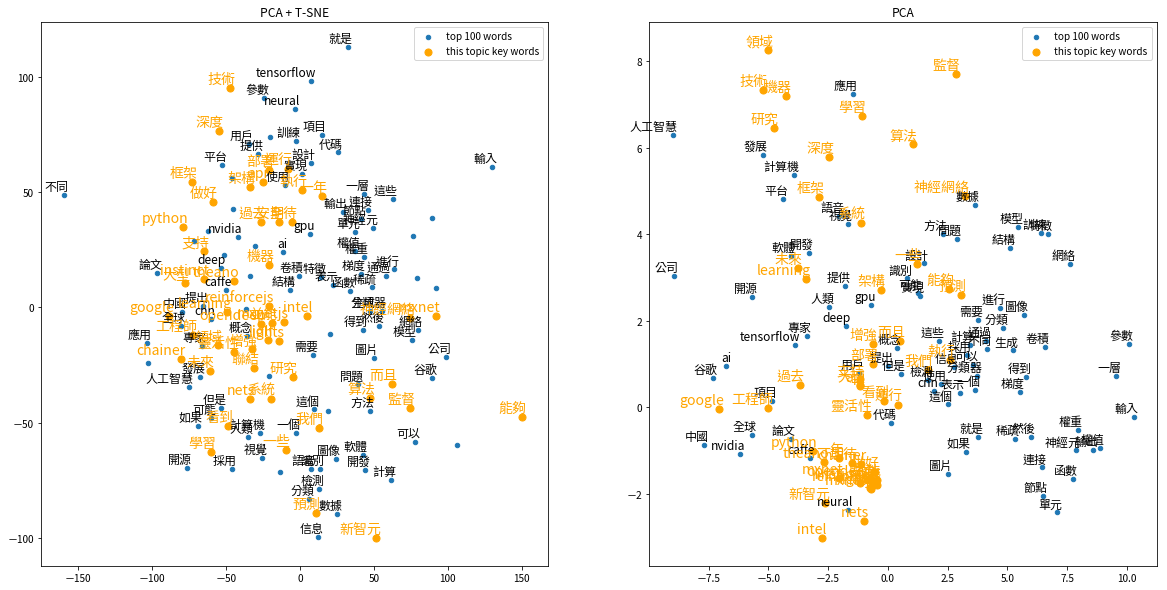

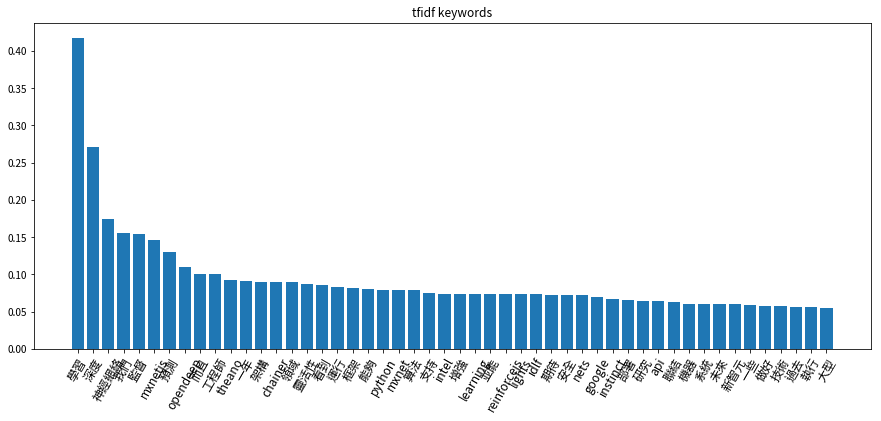

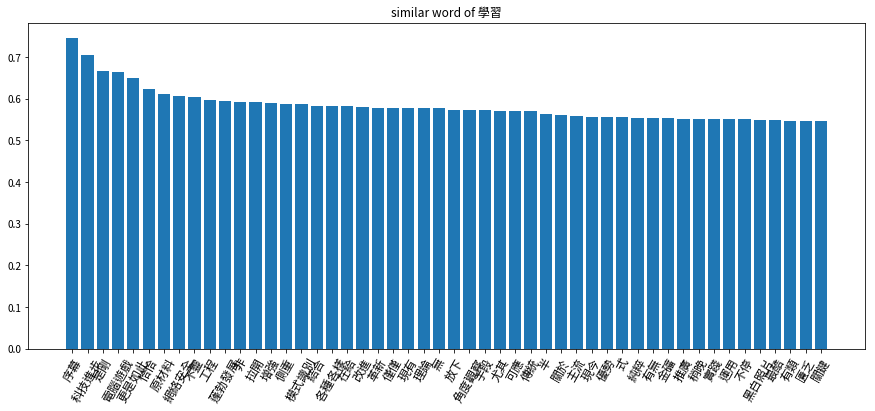

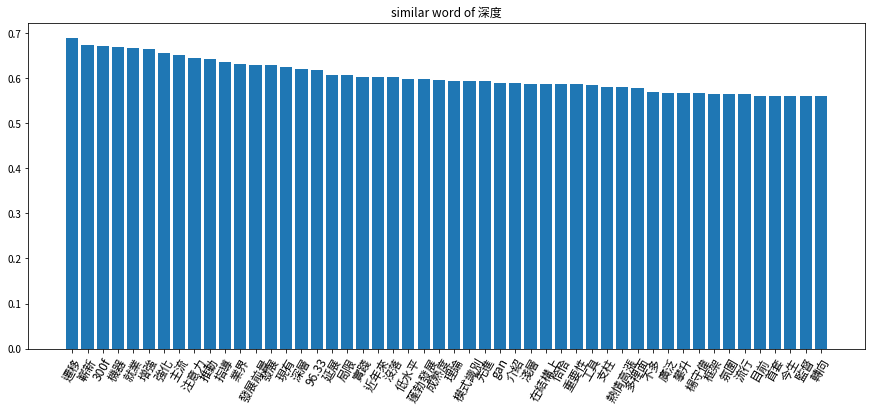

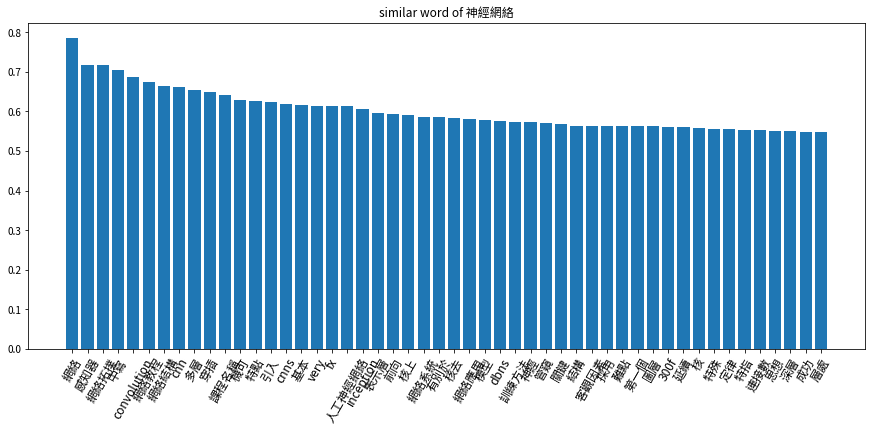

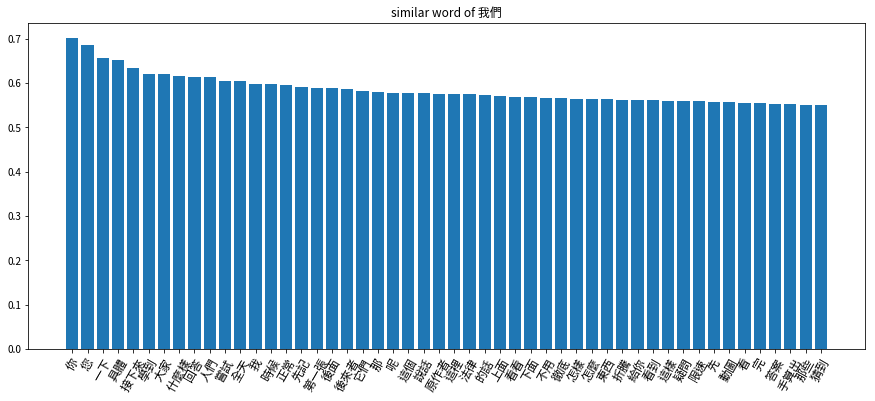

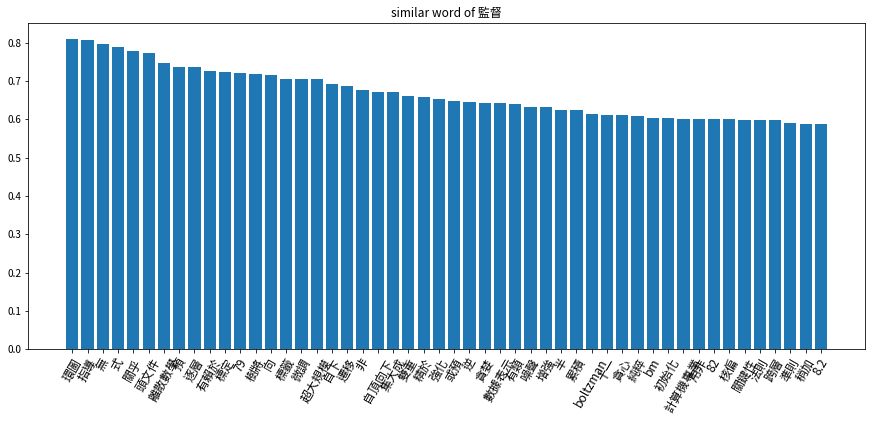

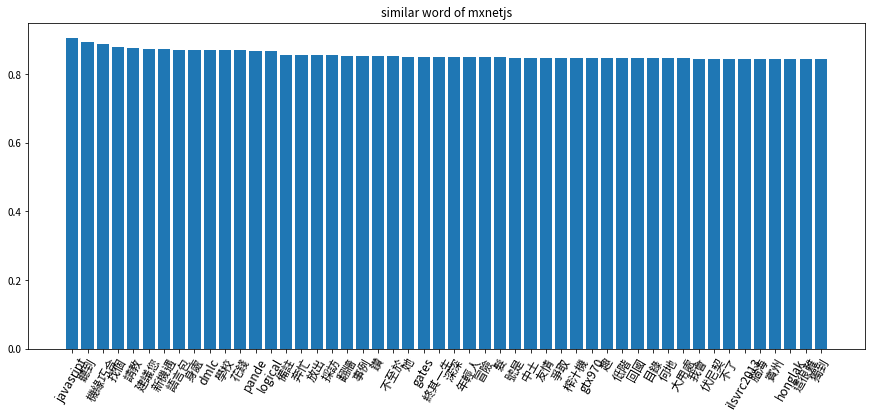

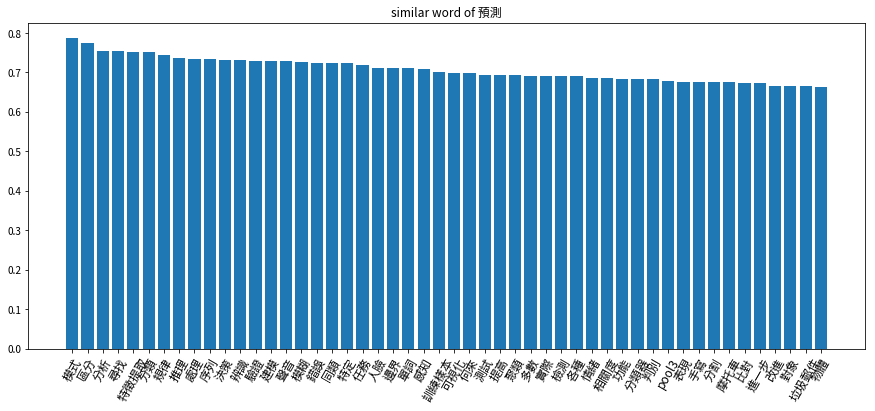

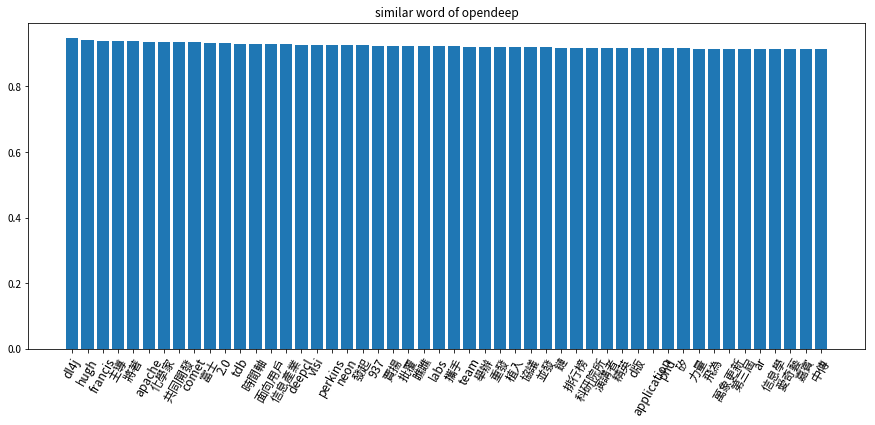

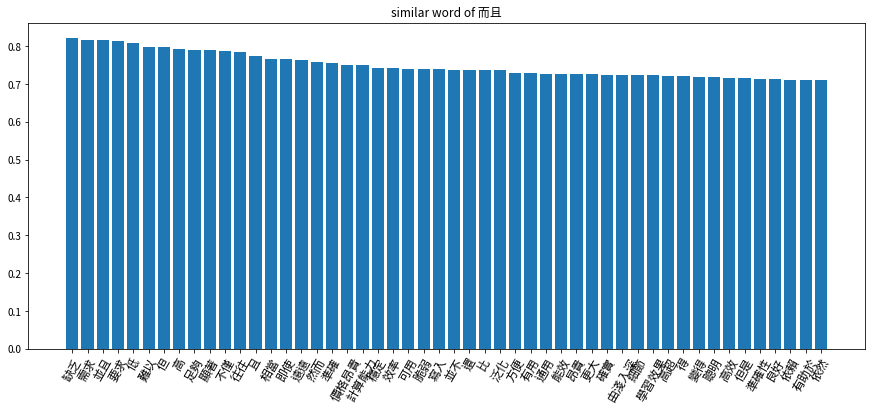

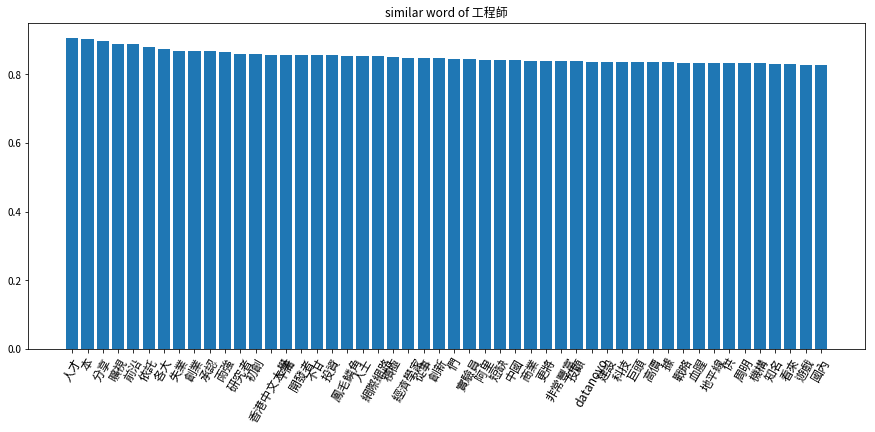

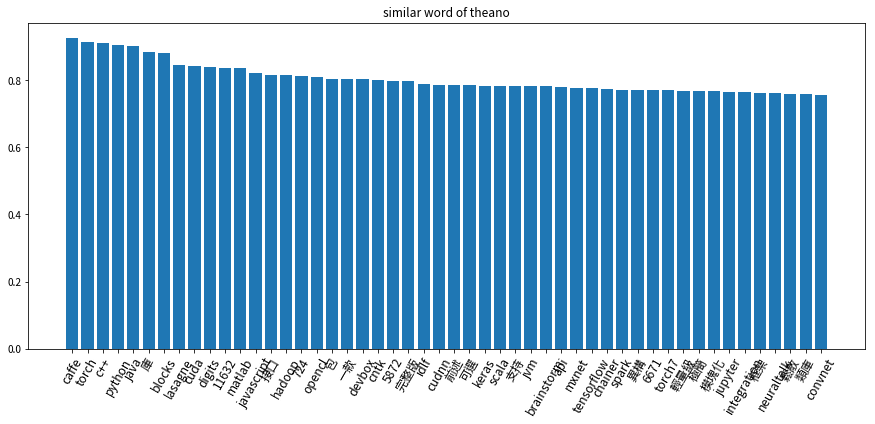

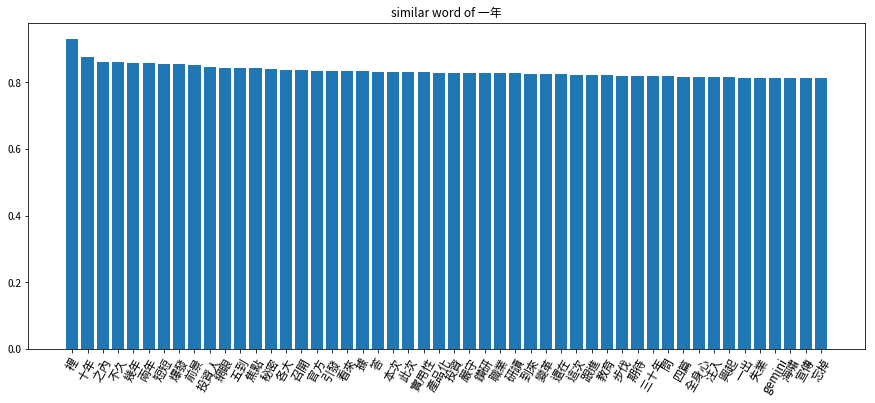

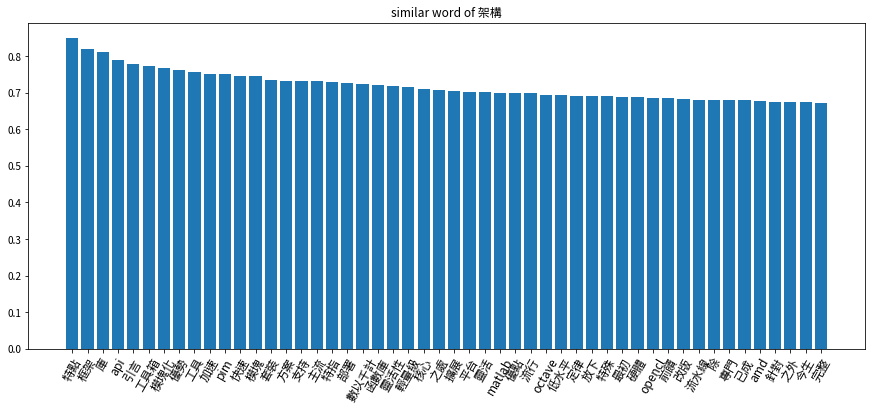

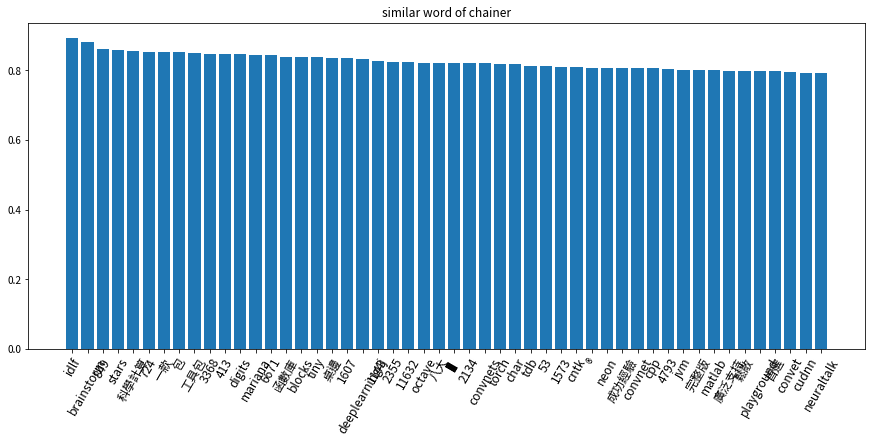

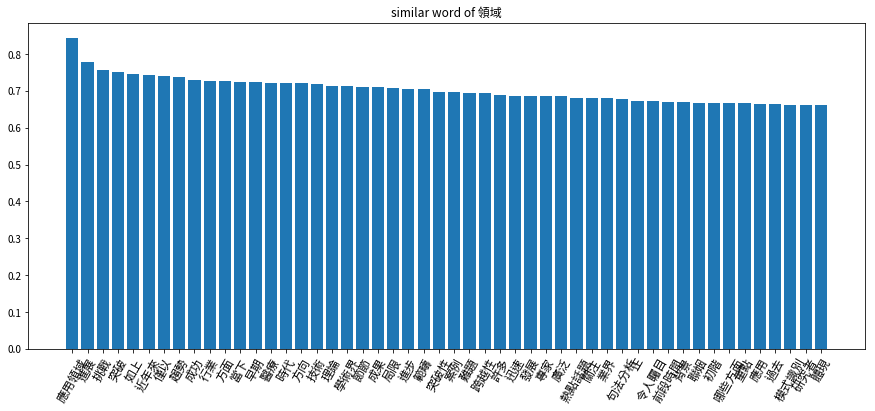

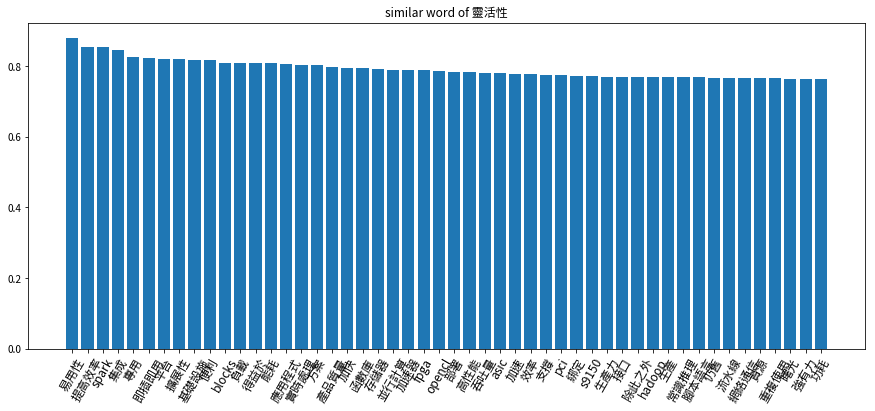

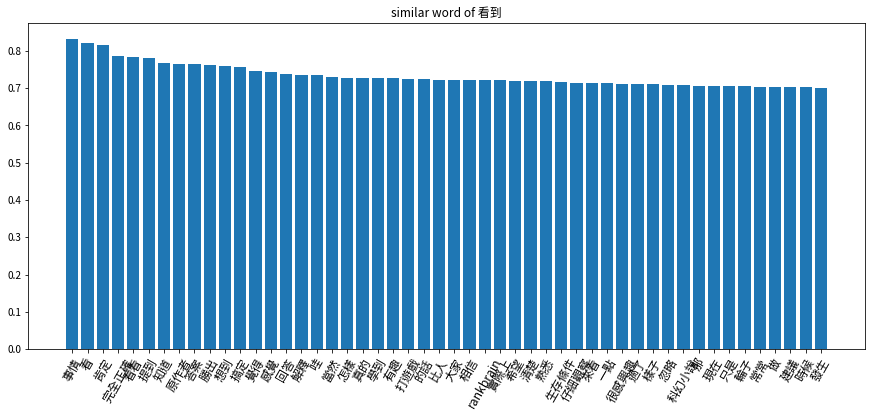

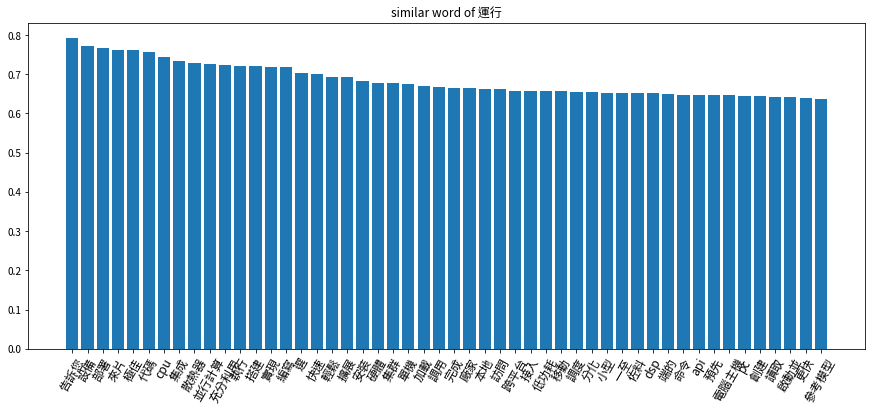

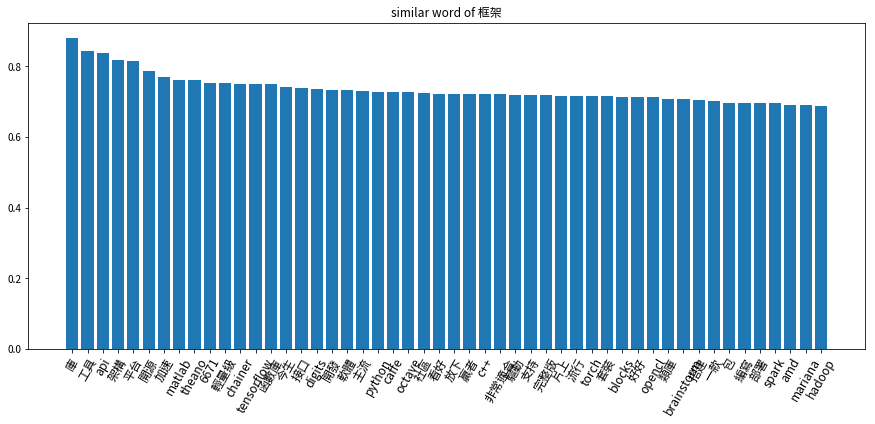

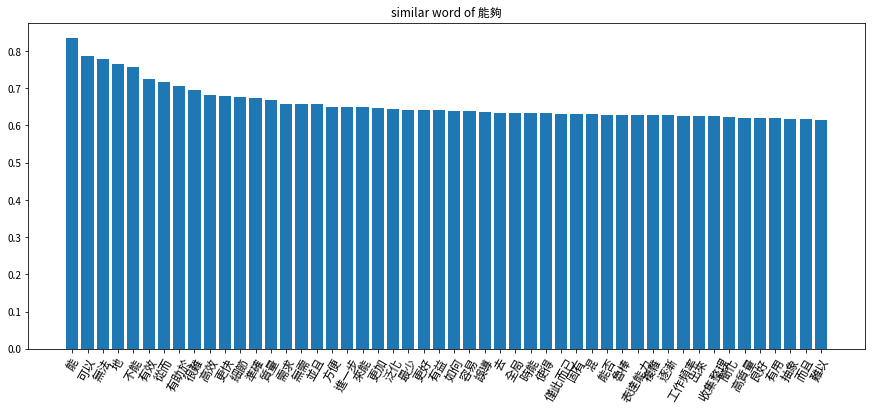

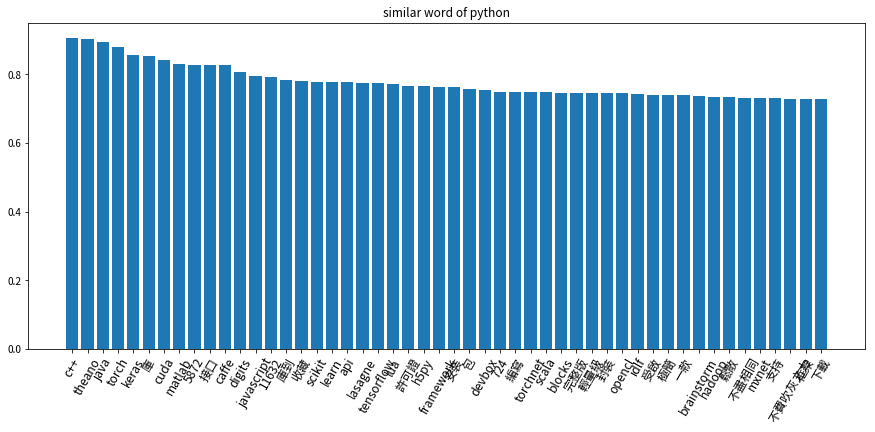

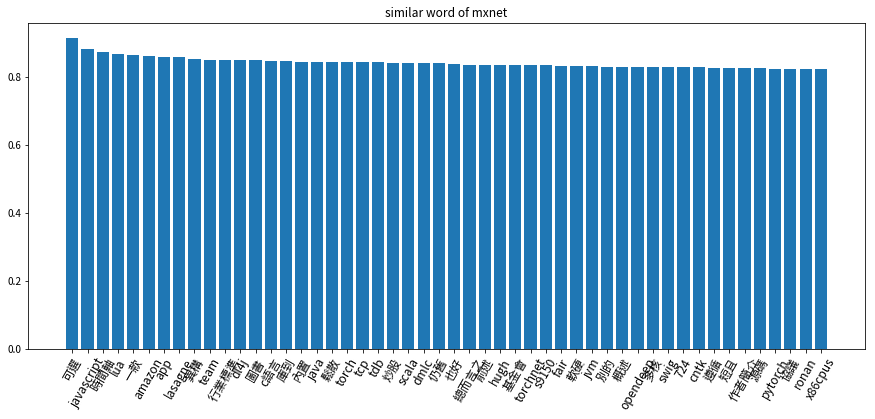

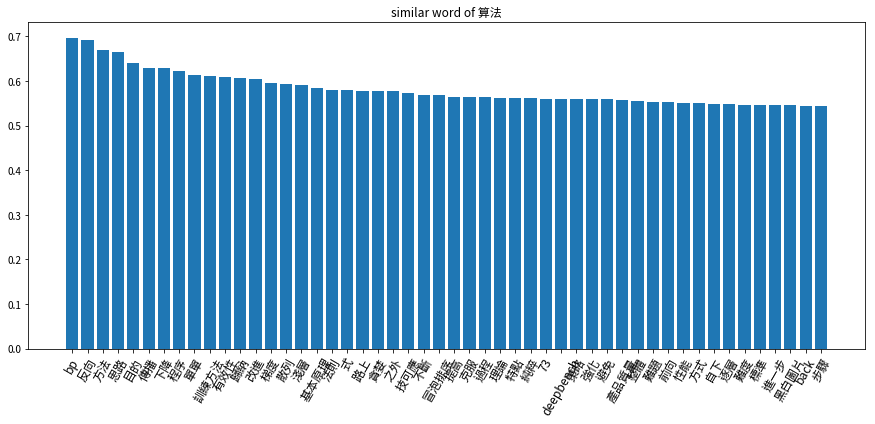

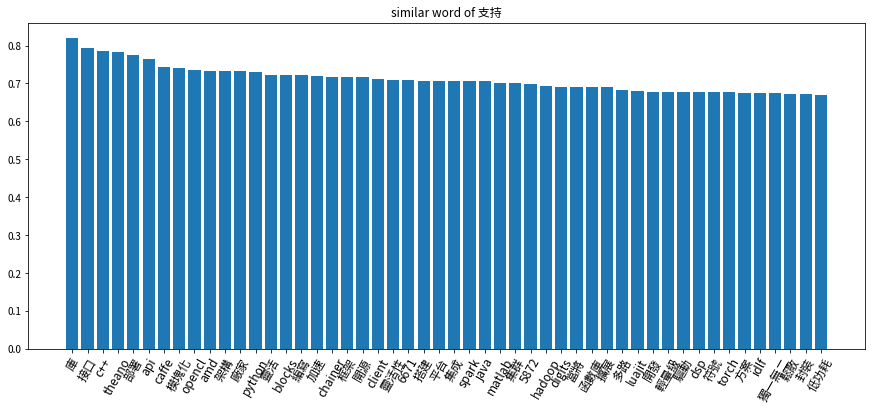

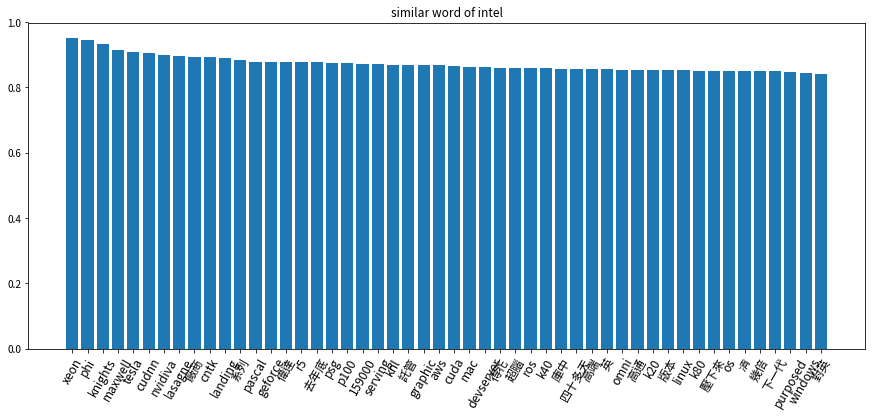

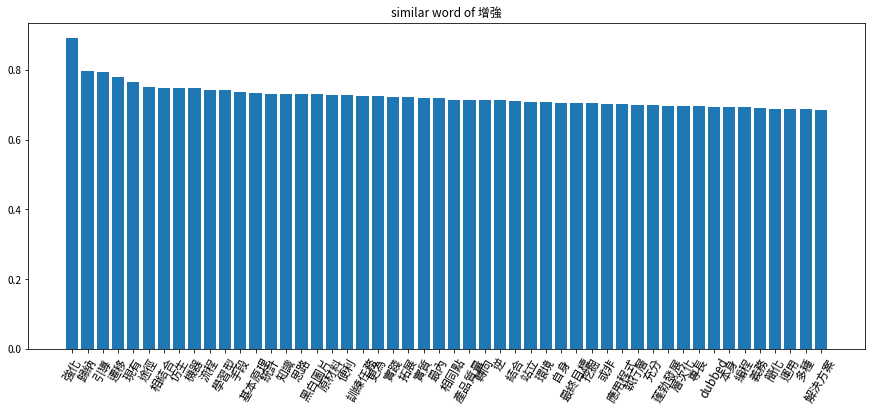

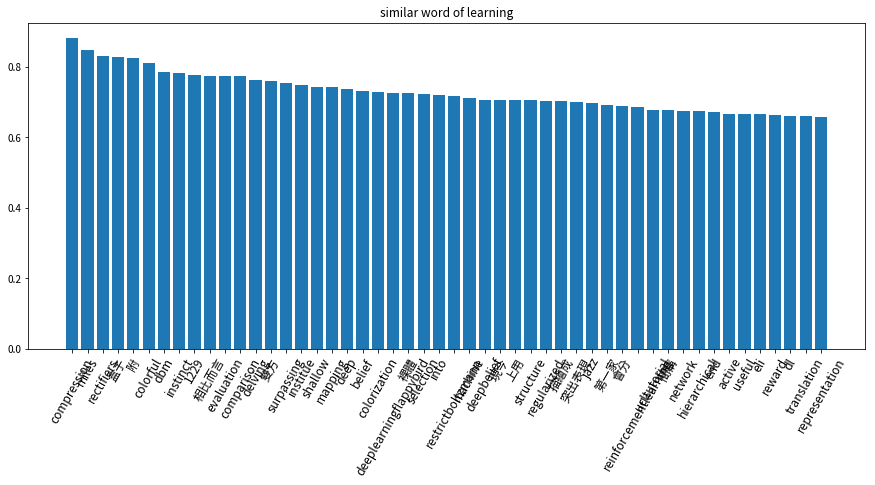

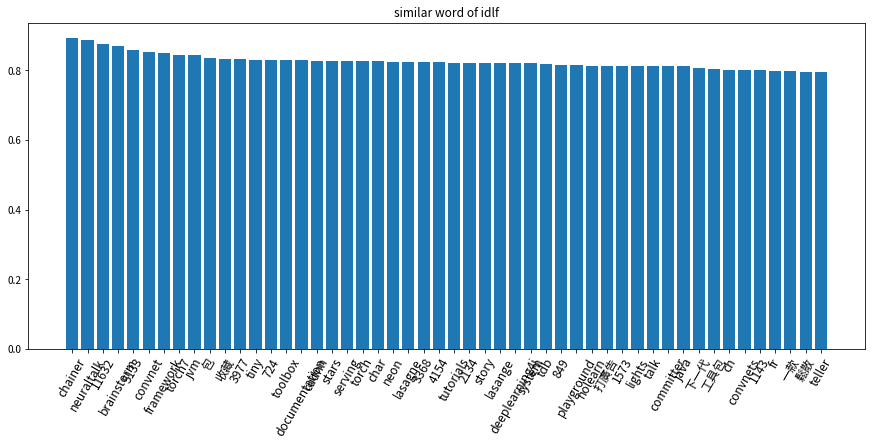

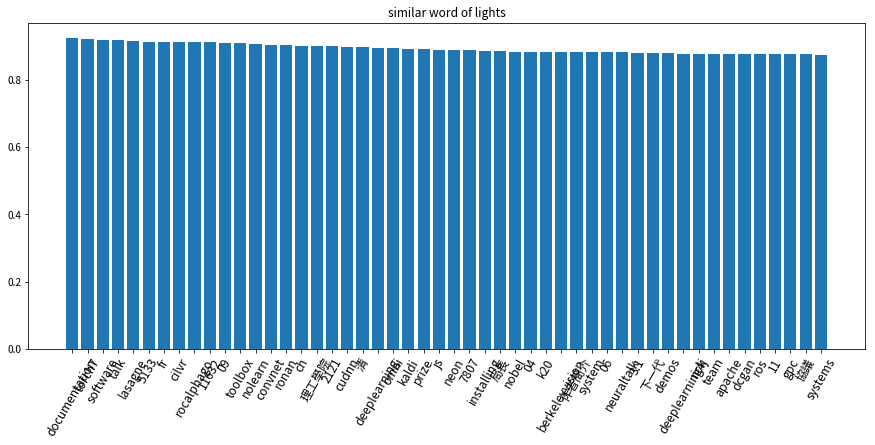

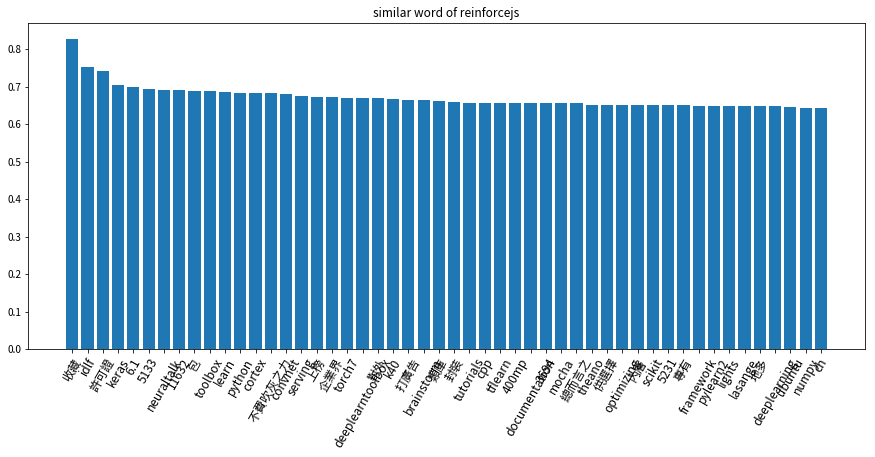

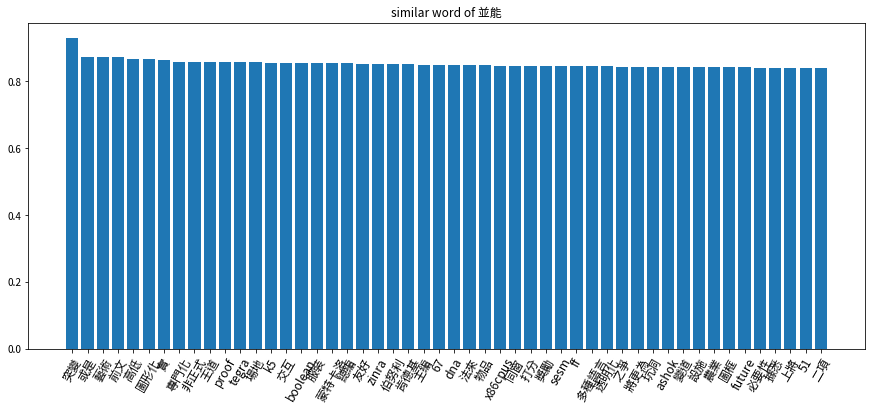

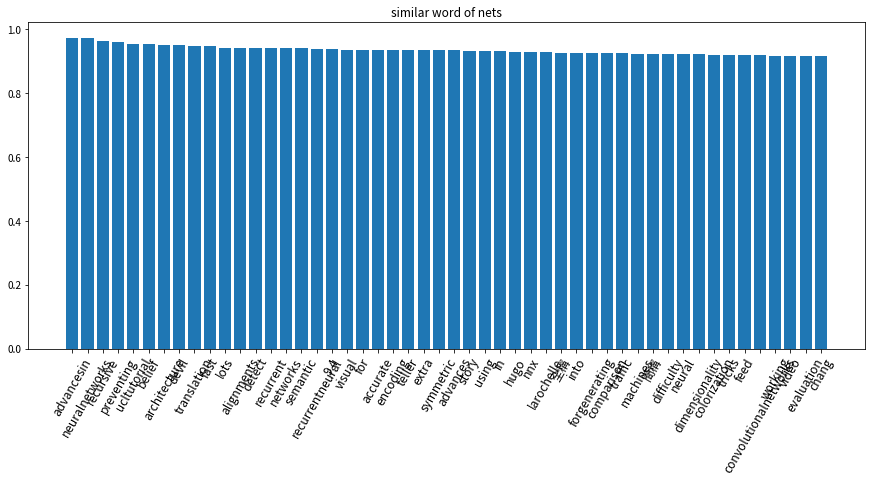

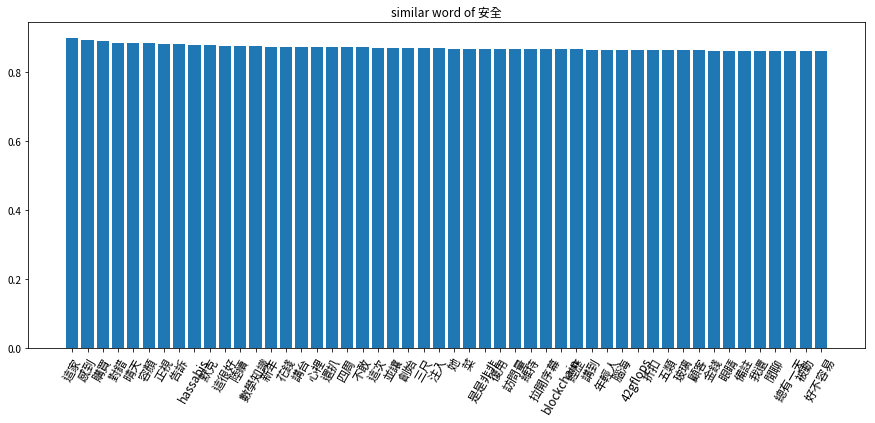

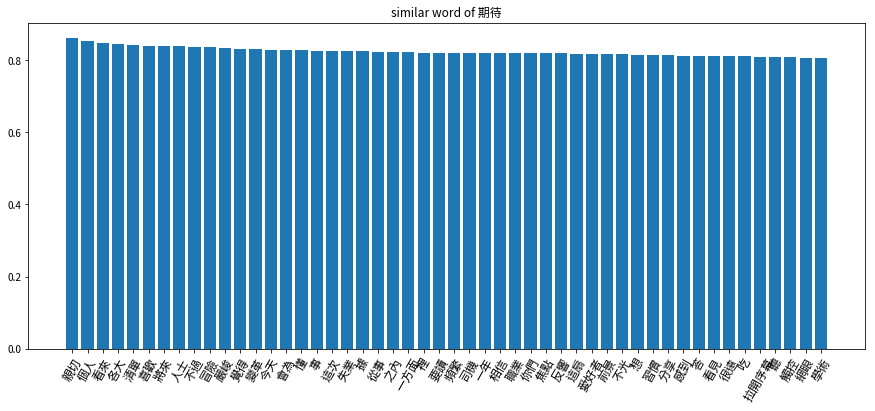

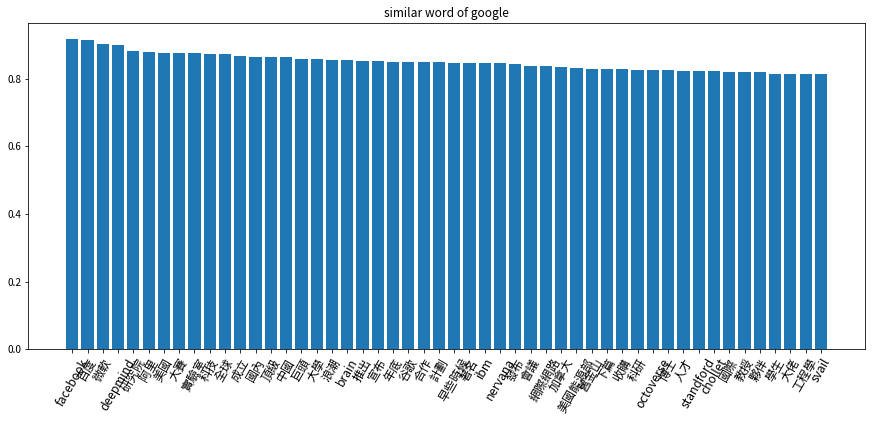

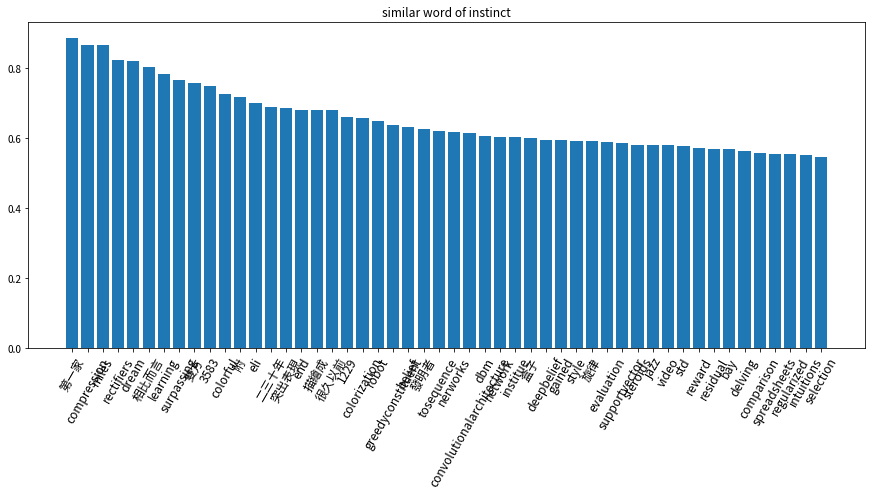

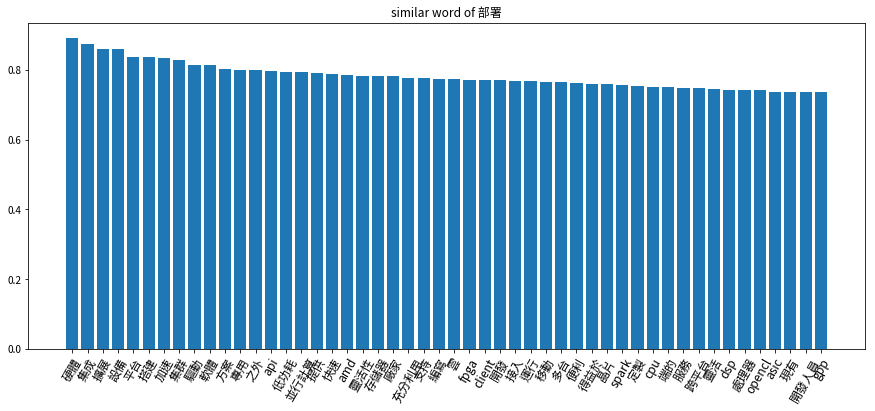

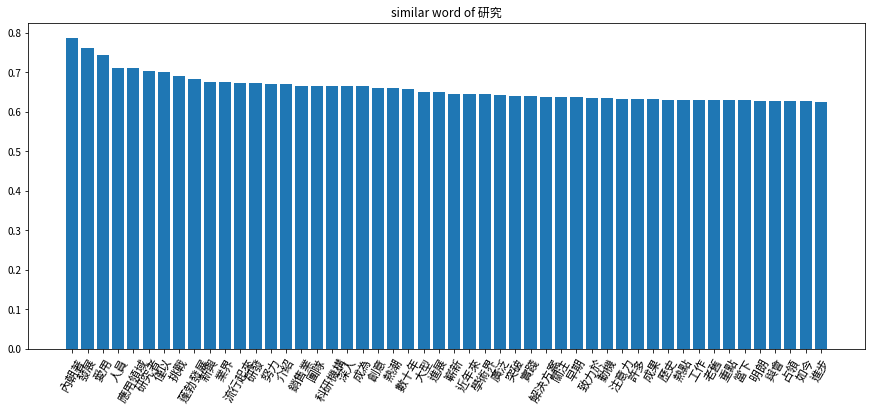

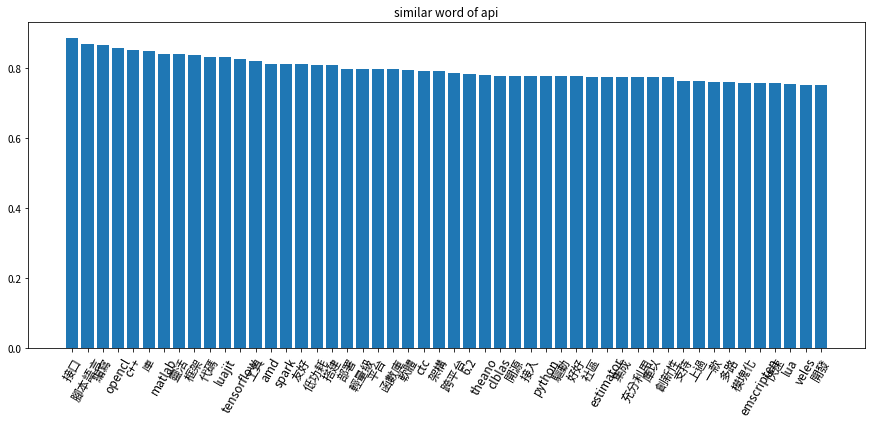

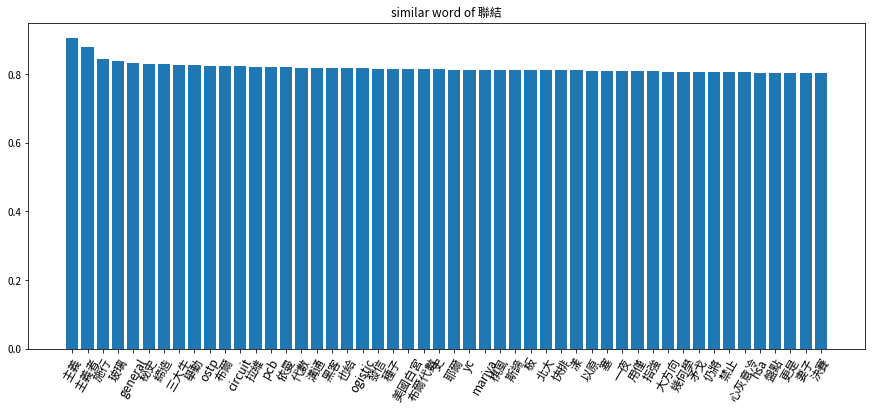

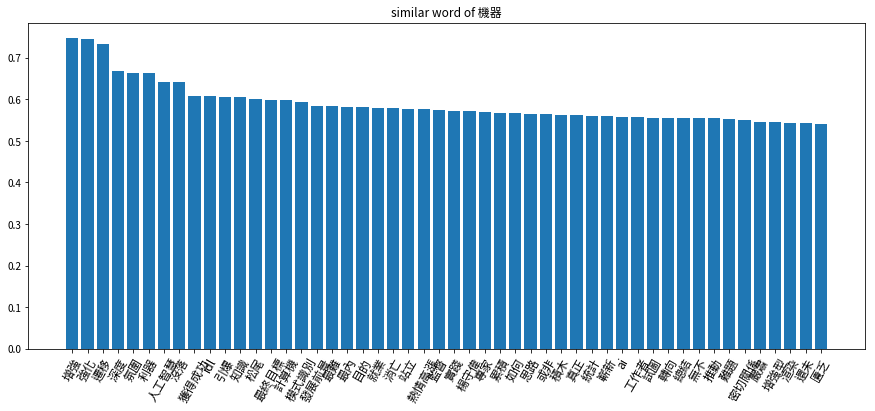

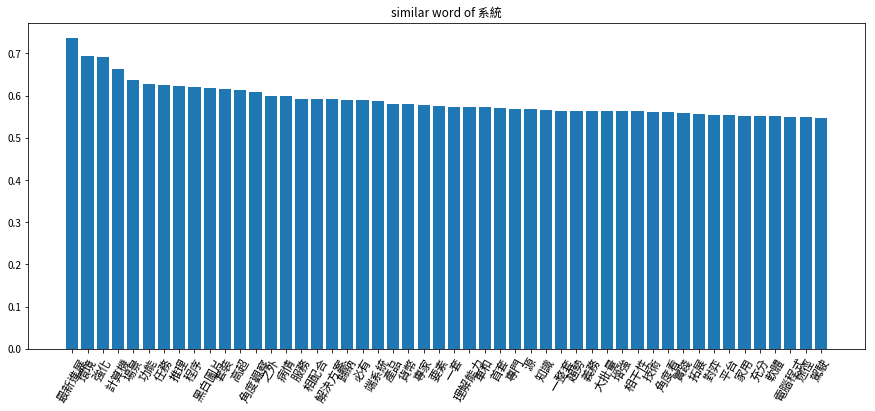

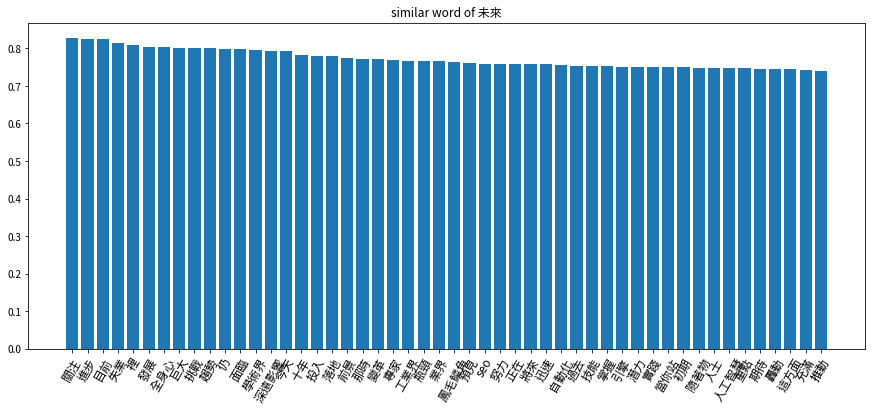

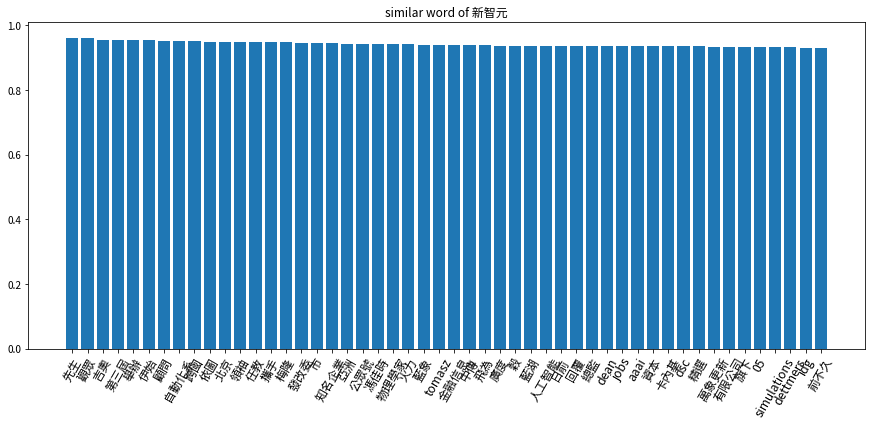

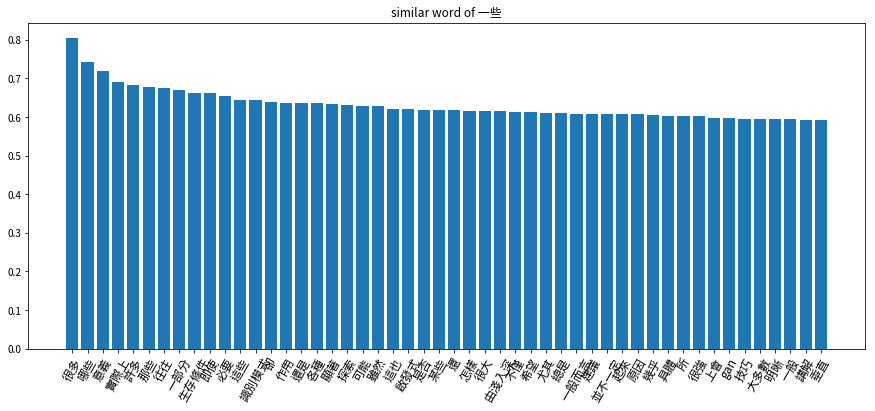

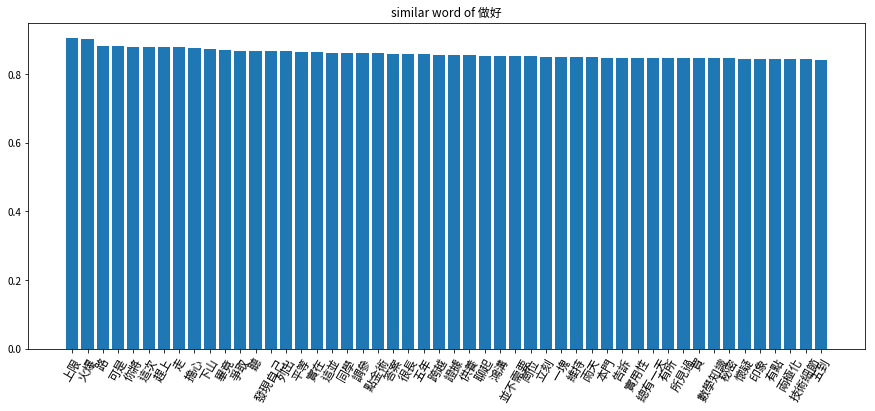

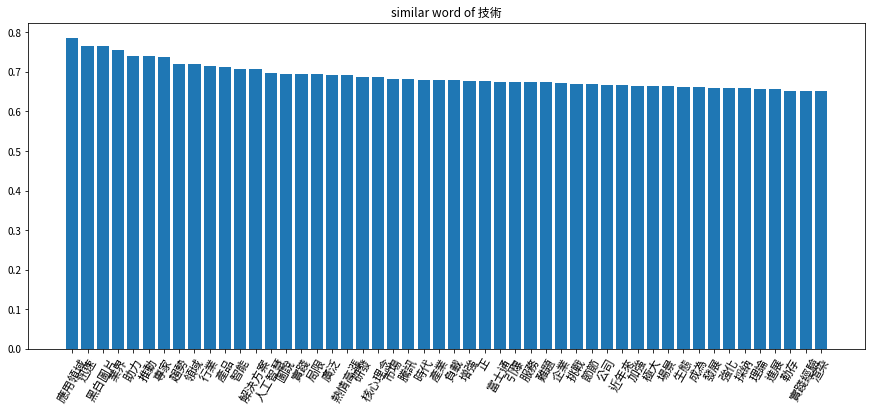

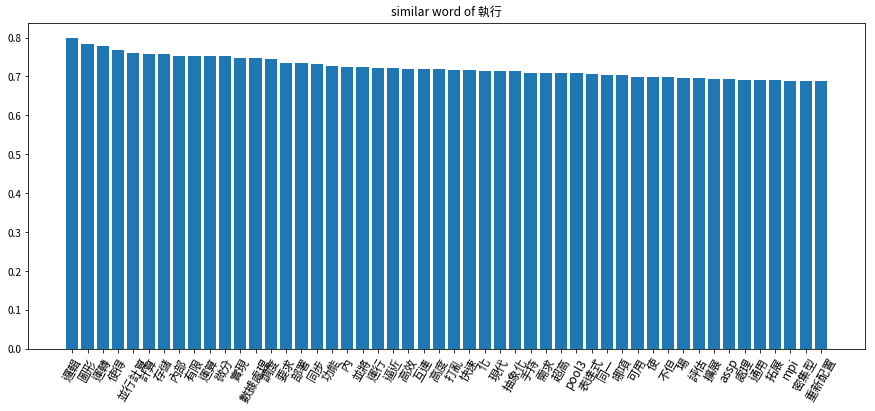

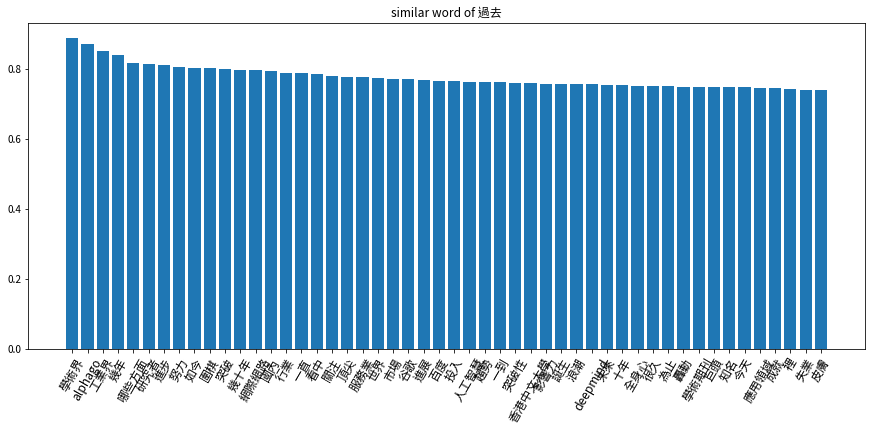

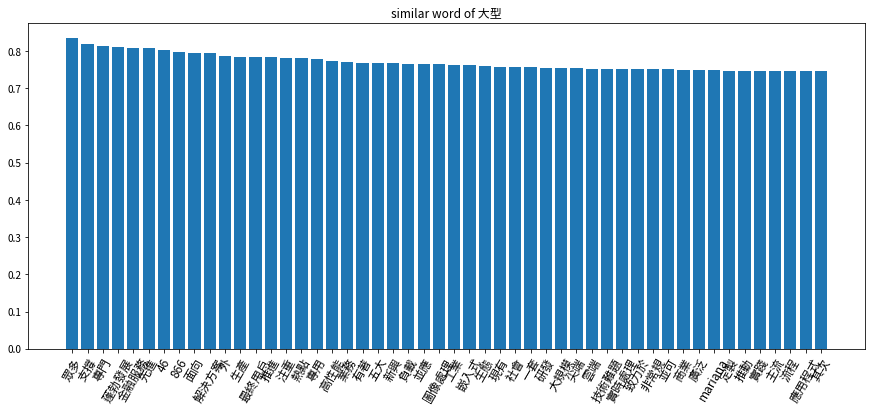

In [114]:
urls = [
    ['', '', '/', '']
    , ['deeplearningSummary', 'docid,topic', '/deeplearningSummary/0/4', 'test']
    , ['lyricsSummary', 'lyricid,who', '/lyricsSummary/0/0', 'test']
    , ['meetingSummary', 'meetingid', '/meetingSummary/0', 'test']
]
df_url = pd.DataFrame(urls, columns=['page', 'ps', 'instance', 'remark']).set_index('page')
df_url['instance'] = df_url['instance'].map(lambda x: '<a href="%s">%s</a>'%(x, x) if x != '' else '')


app = Flask(__name__)

def get_ps(page, path):
    names = df_url.ix[page]['ps'].split(',')
    try:
        ps = {k: v for k, v in zip(names, path.split('/'))}
    except:
        ps = {}
    return ps

def get_route(df_url, page):
    return '/%s'%page + ''.join(['/<%s>'%_ for _ in df_url.ix[page]['ps'].split(',') if len(_)>0 ])

@app.route('/')
def root(**ps):    
    cards = [['URL', [['table', df_url.reset_index()[['page', 'instance', 'ps', 'remark']]]] ]]
    try:
        texts = ['hi, %s'%flask_login.current_user.id]
    except:
        texts = []
    return ht.HtmlTemplate('Root', cards=cards, texts=texts).to_html()


topic_list=[w for w in os.listdir('text_dl') if not w.startswith('.')]
topic=-1
dl_df=None
dl_w2v_model=None
dl_pca=None
dl_voc_dic=None
@app.route('/deeplearningSummary/<path:path>')
def deeplearningSummary(path=''):
    global topic
    global dl_df
    global dl_w2v_model
    global dl_pca
    global dl_voc_dic
    #print(path)
    ps={}
    ps = get_ps('deeplearningSummary', path)
    #print(ps)
    docid = int(ps.get('docid'))  #docid
    topic_new = int(ps.get('topic'))  #topic
    print(topic_new)
    topic_str = topic_list[topic_new]
    
    if topic!=topic_new:
        dl_df, dl_voc_dic, dl_w2v_model, dl_pca = read01_summary(folder = 'text/techdoc', topic=topic_str, kw_topn=50)
        tipic=topic_new
    
    selected_doc = dl_df.ix[docid]
    
    cards = []
    content=[]
    
    display_detailcols=['fname', 'doc', 'keywords', 'summary']
    for col in display_detailcols:
        content.append(['text', '<font color="blue">{col}</font>'.format(col=col)])
        content.append(['text',selected_doc[col]])
    
    similarwords=OrderedDict()
    for kw in list(dl_df['keywords'][0]):
        similarword=dl_w2v_model.most_similar(kw,topn=20)
        similarwords[kw]=similarword
    similarwords_df = pd.DataFrame(similarwords)
    content.append(['text', '<font color="blue">{col}</font>'.format(col='similar words')])
    content.append(['table',similarwords_df])
    
    content.append(['text', '<font color="blue"> Text Summary</font>'])
    content.append(['table', dl_df[['fname','keywords','summary']]])
    
    cards.append(['text summary', content ])
    
    figs = keywordmap(dl_df, docid, dl_w2v_model, dl_pca,dl_voc_dic, kw_size=50)
    
    content=[]
    for f in figs:
        content.append(['fig', f])
    cards.append(['keyword map', content ])

    
    controls = []
    controls.append( ht.Control_Select(id='docid', text='doc', options=list(range(dl_df.shape[0])), value=docid, labels=list((dl_df['fname'])) ))
    controls.append( ht.Control_Select(id='topic', text='topic', options=list(range(len(topic_list))), value=topic_new, labels=topic_list ))
    
    return ht.HtmlTemplate('Text Summary App', ps, cards, controls=controls, page='deeplearningSummary').to_html()


who_list=[w for w in os.listdir('text') if not w.startswith('.')]
who=-1
df=None
w2v_model=None
pca=None
voc_dic=None
@app.route('/lyricsSummary/<path:path>')
def lyricsSummary(path=''):
    global who
    global df
    global w2v_model
    global pca
    global voc_dic
    #print(path)
    ps={}
    ps = get_ps('lyricsSummary', path)
    #print(ps)
    lyricid = int(ps.get('lyricid'))
    who_new = int(ps.get('who'))
    print(who_new)
    who_str = who_list[who_new]
    
    if who!=who_new:
        #df = lyrics_summary(who_str)
        df, voc_dic, w2v_model, pca = lyrics_summary('text/lyrics', who_str)
        who=who_new
        #w2v_model = Word2Vec(df['words'], min_count=1, size=100,iter=20)
        #all_keywords = sum(list(df['keywords']),[])
        #vec = np.array([w2v_model[w] for w in all_keywords if w in w2v_model ])
        #pca = PCA(20)
        #pca.fit(vec)
    
    selected_lyrics = df.ix[lyricid]
    
    cards = []
    #cards.append(['case', [['lyrics', '<font color="blue"> Lyrics Summary</font>'], ['table', df[['doc','keywords','summary']]]]])
    
    content=[]
    
    display_detailcols=['fname', 'doc', 'keywords', 'summary']
    for col in display_detailcols:
        content.append(['text', '<font color="blue">{col}</font>'.format(col=col)])
        content.append(['text',selected_lyrics[col]])
    
    content.append(['text', '<font color="blue"> Lyrics Summary</font>'])
    content.append(['table', df[['fname','keywords','summary']]])
    
    cards.append(['lyrics summary', content ])

    figs = keywordmap(df, lyricid, w2v_model, pca,voc_dic)
    
    content=[]
    for f in figs:
        content.append(['fig', f])
    cards.append(['keyword map', content ])

    
    controls = []
    controls.append( ht.Control_Select(id='track', text='Select', options=list(range(df.shape[0])), value=lyricid, labels=list((df['fname'])) ))
    controls.append( ht.Control_Select(id='who', text='Select', options=list(range(len(who_list))), value=who, labels=who_list ))
    
    return ht.HtmlTemplate('Lyrics Summary App', ps, cards, controls=controls, page='lyricsSummary').to_html()


mts_df=None
mts_w2v_model=None
mts_pca=None
mts_voc_dic=None
hasloadfile=False
@app.route('/meetingSummary/<path:path>')
def meetingSummary(path=''):
    global mts_df
    global mts_w2v_model
    global mts_pca
    global hasloadfile
    global mts_voc_dic
    #print(path)
    ps={}
    ps = get_ps('meetingSummary', path)
    #print(ps)
    meetingid = int(ps.get('meetingid'))
    
    if not hasloadfile:
        mts_df, mts_voc_dic, mts_w2v_model, mts_pca = mark_summary()
        hasloadfile=True
    
    selected_meeting = mts_df.ix[meetingid]
    cards = []
    content = []
    
    display_detailcols=['fname', 'doc', 'keywords', 'summary']
    for col in display_detailcols:
        content.append(['text', '<font color="blue">{col}</font>'.format(col=col)])
        content.append(['text',selected_meeting[col]])
    
    content.append(['text', '<font color="blue"> Meeting Summary</font>'])
    content.append(['table', mts_df[['fname','keywords','summary']]])
    
    cards.append(['Meeting summary', content ])

    figs = keywordmap(mts_df, meetingid, mts_w2v_model, mts_pca,mts_voc_dic)
    
    content=[]
    for f in figs:
        content.append(['fig', f])
    cards.append(['keyword map', content ])

    
    controls = []
    controls.append( ht.Control_Select(id='doc', text='Select', options=list(range(mts_df.shape[0])), value=meetingid, labels=list((mts_df['fname'])) ))
    
    return ht.HtmlTemplate('Meeting summary', ps, cards, controls=controls, page='meetingSummary').to_html()





if __name__ == '__main__':
    app.run(host='0.0.0.0',port=5001)


In [45]:
#dl_df.head()

***
** 下面都沒用 **

** kmeans **


X = np.array(list(df0['tfidf_vector'].values))
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)
df0['kmeans_group'] = kmeans.predict(X)
df0[['kmeans_group', 'doc']]


# show groups
df0['left_100'] = df0['doc'].map(lambda x: x[:100])
df0.groupby(['kmeans_group', 'left_100']).size().reset_index()


** --- Word2Vec Vectorize and KNN Classifier **
** W2V **

X2= np.array(list(df0['w2v_vector_avg'].values))
w2vkmeans = KMeans(n_clusters=4, random_state=0).fit(X2)
df0['w2v_kmeans_group'] = w2vkmeans.predict(X2)


** word2vec **
 - `size` is the dimensionality of the feature vectors.
 - `window` is the maximum distance between the current and predicted word within a sentence.
 - `min_count` = ignore all words with total frequency lower than this.

w2v_model = Word2Vec(lyrics_df['words'], min_count=1, size=10)
#def words_to_w2v_avg(w2v, words):
#    vecs = np.array([w2v[_] for _ in words if _ in w2v]) # get word's vector in word in w2v's vocabulary
#    return vecs.mean(axis=0) # return average of vectors

#lyrics_df['w2v_vector_avg'] = lyrics_df['words'].map(lambda x: words_to_w2v_avg(w2v, x))

def keywords_to_w2v(w2v,keywords):
    vecs = np.array([w2v[_] for _ in keywords if _ in w2v]) 
    return vecs

lyrics_df['w2v_keywords'] = lyrics_df['keywords'].map(lambda x: keywords_to_w2v(w2v_model, x))

vec=[]
for i in lyrics_df['w2v_keywords']:
    vec.extend(i)
    
vec = np.array(vec)
tsne = TSNE(perplexity=10, n_components=2, init='pca', n_iter=5000)
low_dim_embs = tsne.fit_transform(vec)

tmpst=0
tmpend=0
low_tim_embs_list=[]
for i in lyrics_df['w2v_keywords']:
    tmpend = tmpst+ len(i)
    low_tim_embs_list.append(low_dim_embs[tmpst:tmpend])
    tmpst=tmpst+len(i)
    
lyrics_df['tsne_keywordsw2v'] = low_tim_embs_list
    

plt.figure(figsize=(13,13))

for row in range(lyrics_df.shape[0]):
    keywords_w2v_vecs= lyrics_df['w2v_keywords'][row]
    keywords=lyrics_df['keywords'][row]
    plt.scatter(keywords_w2v_vecs[:, 0], keywords_w2v_vecs[:, 1])
    for i, label in enumerate(keywords):
        x, y = keywords_w2v_vecs[i][:2]
        label = '{a}_{b}'.format(a=row,b=label)
        plt.annotate(label, xy=(x, y), fontsize=10, ha='right', va='bottom')
plt.title('Word2Vec')
            
plt.figure(figsize=(13,13))

for row in range(lyrics_df.shape[0]):
    keywords_w2v_vecs= lyrics_df['tsne_keywordsw2v'][row]
    keywords=lyrics_df['keywords'][row]
    plt.scatter(keywords_w2v_vecs[:, 0], keywords_w2v_vecs[:, 1])
    for i, label in enumerate(keywords):
        x, y = keywords_w2v_vecs[i][:2]
        label = '{a}_{b}'.format(a=row,b=label)
        plt.annotate(label, xy=(x, y), fontsize=12, ha='right', va='bottom')
plt.title('Word2Vec + TSNE')

